In [2]:
# Microscopy Image Deconvolution with PSF Generation - Google Colab Version
# For OME-TIFF file: "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"

# First, mount Google Drive (run this cell first)
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install tifffile matplotlib scipy napari[all] pyqt5 PyOpenGL

# Import necessary libraries
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from xml.etree import ElementTree as ET
from scipy import ndimage, signal
import time
from pathlib import Path
import os


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Define functions for metadata extraction, PSF generation, and deconvolution

def extract_ome_metadata(ome_tiff_path):
    """Extract relevant metadata from OME-TIFF file."""
    with tifffile.TiffFile(ome_tiff_path) as tif:
        # Get OME XML metadata
        ome_metadata = tif.ome_metadata

        if ome_metadata is None:
            print("No OME metadata found. Using default values...")
            # Create default metadata based on image dimensions
            image = tif.asarray()
            if len(image.shape) == 3:  # Z, Y, X
                sizeZ, sizeY, sizeX = image.shape
                sizeC = 1
            elif len(image.shape) == 4:  # C, Z, Y, X
                sizeC, sizeZ, sizeY, sizeX = image.shape
            else:
                sizeZ = 1
                sizeC = 1
                if len(image.shape) == 2:
                    sizeY, sizeX = image.shape
                else:
                    raise ValueError(f"Unsupported image shape: {image.shape}")

            metadata = {
                'SizeX': sizeX,
                'SizeY': sizeY,
                'SizeZ': sizeZ,
                'SizeC': sizeC,
                'PhysicalSizeX': 0.1,  # Default 100 nm per pixel
                'PhysicalSizeY': 0.1,
                'PhysicalSizeZ': 0.5,  # Default 500 nm z-step
                'PhysicalSizeXUnit': 'µm',
                'PhysicalSizeYUnit': 'µm',
                'PhysicalSizeZUnit': 'µm',
                'Type': 'uint16',
                'NA': 1.2,  # Default objective NA
                'NominalMagnification': 60,  # Default magnification
                'Immersion': 'Oil',
                'Channels': []
            }

            # Add default channel information
            default_wavelengths = [(405, 450), (488, 525), (561, 600)]
            for i in range(sizeC):
                ex_wave, em_wave = default_wavelengths[i] if i < len(default_wavelengths) else (488, 525)
                metadata['Channels'].append({
                    'Index': i,
                    'Name': f'Channel {i}',
                    'ExcitationWavelength': ex_wave,
                    'EmissionWavelength': em_wave,
                })

            return metadata

        # Parse XML if we have OME metadata
        root = ET.fromstring(ome_metadata)

        # Define namespace for OME XML
        ns = {'ome': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}

        # Extract image dimensions
        pixels = root.find('.//ome:Pixels', ns)
        if pixels is None:
            raise ValueError("No Pixels element found in OME metadata")

        metadata = {
            'SizeX': int(pixels.get('SizeX')),
            'SizeY': int(pixels.get('SizeY')),
            'SizeZ': int(pixels.get('SizeZ')),
            'SizeC': int(pixels.get('SizeC')),
            'PhysicalSizeX': float(pixels.get('PhysicalSizeX', 0.1)),
            'PhysicalSizeY': float(pixels.get('PhysicalSizeY', 0.1)),
            'PhysicalSizeZ': float(pixels.get('PhysicalSizeZ', 0.5)),
            'PhysicalSizeXUnit': pixels.get('PhysicalSizeXUnit', 'µm'),
            'PhysicalSizeYUnit': pixels.get('PhysicalSizeYUnit', 'µm'),
            'PhysicalSizeZUnit': pixels.get('PhysicalSizeZUnit', 'µm'),
            'Type': pixels.get('Type', 'uint16'),
        }

        # Try to extract microscope/objective information
        instrument = root.find('.//ome:Instrument', ns)
        if instrument is not None:
            objective = instrument.find('.//ome:Objective', ns)
            if objective is not None:
                metadata['NA'] = float(objective.get('LensNA', 1.2))
                metadata['NominalMagnification'] = float(objective.get('NominalMagnification', 60))
                metadata['Immersion'] = objective.get('Immersion', 'Oil')

        # Extract channel information
        metadata['Channels'] = []
        for i, channel in enumerate(root.findall('.//ome:Channel', ns)):
            ch_metadata = {
                'Index': i,
                'Name': channel.get('Name', f'Channel {i}'),
                'ExcitationWavelength': float(channel.get('ExcitationWavelength', 488)),
                'EmissionWavelength': float(channel.get('EmissionWavelength', 525)),
            }
            metadata['Channels'].append(ch_metadata)

        # Fill in default values for channels if none were found
        if not metadata['Channels']:
            default_wavelengths = [(405, 450), (488, 525), (561, 600)]
            for i in range(metadata['SizeC']):
                ex_wave, em_wave = default_wavelengths[i] if i < len(default_wavelengths) else (488, 525)
                metadata['Channels'].append({
                    'Index': i,
                    'Name': f'Channel {i}',
                    'ExcitationWavelength': ex_wave,
                    'EmissionWavelength': em_wave,
                })

        return metadata


def load_image_data(ome_tiff_path):
    """Load image data from TIFF file, handling both OME-TIFF and regular TIFF."""
    with tifffile.TiffFile(ome_tiff_path) as tif:
        # Extract basic metadata
        metadata = extract_ome_metadata(ome_tiff_path)

        # Load the image data
        image_data = tif.asarray()

        # Reshape the data if necessary to ensure it's organized as (C, Z, Y, X)
        if len(image_data.shape) == 2:  # Single 2D image
            image_data = image_data.reshape(1, 1, *image_data.shape)
        elif len(image_data.shape) == 3:  # Could be (Z, Y, X) or multiple 2D images
            if metadata['SizeZ'] > 1:
                image_data = image_data.reshape(1, *image_data.shape)  # (1, Z, Y, X)
            else:
                image_data = image_data.reshape(metadata['SizeC'], 1, *image_data.shape[1:])  # (C, 1, Y, X)
        elif len(image_data.shape) == 4:  # Could be multiple formats
            # Assume it's (C, Z, Y, X) for simplicity
            pass
        else:
            raise ValueError(f"Unsupported image shape: {image_data.shape}")

        # Verify dimensions match metadata
        if image_data.shape[-2] != metadata['SizeY'] or image_data.shape[-1] != metadata['SizeX']:
            print(f"Warning: Image dimensions {image_data.shape[-2:]} don't match metadata {(metadata['SizeY'], metadata['SizeX'])}")

            # Update metadata to match actual dimensions
            metadata['SizeY'] = image_data.shape[-2]
            metadata['SizeX'] = image_data.shape[-1]

        if len(image_data.shape) >= 3 and image_data.shape[-3] != metadata['SizeZ']:
            print(f"Warning: Z dimension {image_data.shape[-3]} doesn't match metadata {metadata['SizeZ']}")
            metadata['SizeZ'] = image_data.shape[-3]

        if len(image_data.shape) >= 4 and image_data.shape[0] != metadata['SizeC']:
            print(f"Warning: Channel count {image_data.shape[0]} doesn't match metadata {metadata['SizeC']}")
            metadata['SizeC'] = image_data.shape[0]

            # Adjust channel metadata if needed
            while len(metadata['Channels']) < metadata['SizeC']:
                i = len(metadata['Channels'])
                metadata['Channels'].append({
                    'Index': i,
                    'Name': f'Channel {i}',
                    'ExcitationWavelength': 488,
                    'EmissionWavelength': 525,
                })

        return image_data, metadata


def generate_theoretical_psf(metadata, channel_idx=0, psf_size=None):
    """
    Generate a theoretical PSF based on the microscope parameters.
    This is a simplified model based on a 3D Gaussian approximation.
    """
    # Get channel-specific metadata
    channel = metadata['Channels'][channel_idx]
    emission_wavelength = channel['EmissionWavelength'] / 1000  # Convert to µm

    # Get objective properties
    na = metadata.get('NA', 1.2)
    pixel_size_x = metadata['PhysicalSizeX']
    pixel_size_y = metadata['PhysicalSizeY']
    pixel_size_z = metadata['PhysicalSizeZ']

    # Calculate PSF dimensions if not provided
    if psf_size is None:
        # Default PSF size - adjust as needed for your application
        psf_size_xy = max(21, int(10 * emission_wavelength / pixel_size_x))
        psf_size_z = max(21, int(10 * emission_wavelength / pixel_size_z))

        # Ensure odd dimensions for PSF
        psf_size_xy = psf_size_xy + 1 if psf_size_xy % 2 == 0 else psf_size_xy
        psf_size_z = psf_size_z + 1 if psf_size_z % 2 == 0 else psf_size_z

        psf_size = (psf_size_z, psf_size_xy, psf_size_xy)

    # Create coordinate grids
    z, y, x = np.ogrid[
        -psf_size[0]//2:psf_size[0]//2+1,
        -psf_size[1]//2:psf_size[1]//2+1,
        -psf_size[2]//2:psf_size[2]//2+1
    ]

    # Convert to physical coordinates
    x = x * pixel_size_x
    y = y * pixel_size_y
    z = z * pixel_size_z

    # Calculate PSF parameters
    # Theoretical lateral and axial resolution (Abbe limit)
    lateral_sigma = 0.61 * emission_wavelength / na / pixel_size_x
    axial_sigma = 2 * emission_wavelength / (na**2) / pixel_size_z

    # Create 3D Gaussian PSF
    psf = np.exp(-(x**2 + y**2) / (2 * lateral_sigma**2) - z**2 / (2 * axial_sigma**2))

    # Normalize PSF
    psf = psf / np.sum(psf)

    return psf


def richardson_lucy_deconvolution(image, psf, num_iterations=20, clip=True, callback=None):
    """
    Apply Richardson-Lucy deconvolution algorithm to a 3D image.

    Parameters:
    - image: 3D numpy array (Z, Y, X)
    - psf: Point Spread Function as 3D numpy array
    - num_iterations: Number of iterations for the algorithm
    - clip: Whether to clip values to the range [0, max(image)]
    - callback: Optional callback function to track progress

    Returns:
    - deconvolved image as 3D numpy array
    """
    # Convert to float for computation
    image = image.astype(np.float32)
    psf = psf.astype(np.float32)

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Create reversed PSF for convolution (PSF is symmetric, so this is the same as the PSF)
    psf_reverse = psf[::-1, ::-1, ::-1]

    # Initial estimate is the original image
    estimate = image.copy() + 1e-10  # Add small constant to avoid division by zero

    # Iterative Richardson-Lucy algorithm
    for i in range(num_iterations):
        if callback:
            callback(i, num_iterations)
        else:
            print(f"Deconvolution iteration {i+1}/{num_iterations}")

        # Forward convolution of the estimate with the PSF
        conv_estimate = signal.fftconvolve(estimate, psf, mode='same')

        # Calculate the correction factor
        relative_blur = np.divide(image, conv_estimate, where=conv_estimate > 0)

        # Backward convolution with the reversed PSF
        correction = signal.fftconvolve(relative_blur, psf_reverse, mode='same')

        # Update the estimate
        estimate = estimate * correction

    # Clip values if requested
    if clip:
        estimate = np.clip(estimate, 0, np.max(image))

    return estimate


def process_image_with_progress(input_file, output_dir=None, num_iterations=20):
    """Process a microscopy image with progress reporting for Colab."""
    from IPython.display import display, clear_output
    import ipywidgets as widgets

    # Create output directory if provided
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

    # Load image data and metadata
    print(f"Loading image file: {input_file}")
    image_data, metadata = load_image_data(input_file)

    # Print basic metadata information
    print(f"\nImage Information:")
    print(f"Dimensions: {metadata['SizeX']} x {metadata['SizeY']} x {metadata['SizeZ']}")
    print(f"Channels: {metadata['SizeC']}")
    print(f"Pixel Size: {metadata['PhysicalSizeX']} x {metadata['PhysicalSizeY']} x {metadata['PhysicalSizeZ']} {metadata['PhysicalSizeXUnit']}")

    if 'NA' in metadata:
        print(f"Objective: {metadata.get('NominalMagnification', 'Unknown')}x, NA {metadata['NA']}, {metadata.get('Immersion', 'Unknown')} immersion")

    # Create progress widgets
    overall_progress = widgets.IntProgress(
        value=0,
        min=0,
        max=metadata['SizeC'],
        description='Overall:',
        style={'description_width': 'initial'}
    )

    channel_progress = widgets.IntProgress(
        value=0,
        min=0,
        max=num_iterations,
        description='Channel:',
        style={'description_width': 'initial'}
    )

    status_label = widgets.Label(value="Initializing...")

    display(widgets.VBox([overall_progress, channel_progress, status_label]))

    # Process each channel
    deconvolved_channels = []

    for channel_idx in range(metadata['SizeC']):
        overall_progress.value = channel_idx
        channel_progress.value = 0
        status_label.value = f"Processing Channel {channel_idx+1}/{metadata['SizeC']}: {metadata['Channels'][channel_idx]['Name']}"

        channel_info = metadata['Channels'][channel_idx]

        # Extract channel data
        if len(image_data.shape) == 4:  # (C, Z, Y, X)
            channel_data = image_data[channel_idx]
        else:
            raise ValueError(f"Unexpected image data shape: {image_data.shape}")

        # Generate PSF for this channel
        status_label.value = f"Generating PSF for Channel {channel_idx+1}..."
        psf = generate_theoretical_psf(metadata, channel_idx)

        # Progress callback for deconvolution
        def update_progress(iteration, total):
            channel_progress.value = iteration + 1
            status_label.value = f"Deconvolution for Channel {channel_idx+1}: Iteration {iteration+1}/{total}"

        # Apply deconvolution
        status_label.value = f"Applying Richardson-Lucy deconvolution for Channel {channel_idx+1}..."
        start_time = time.time()
        deconvolved = richardson_lucy_deconvolution(
            channel_data, psf, num_iterations=num_iterations, callback=update_progress)
        elapsed_time = time.time() - start_time
        status_label.value = f"Channel {channel_idx+1} completed in {elapsed_time:.2f} seconds"

        deconvolved_channels.append(deconvolved)

        # Save results if output directory is provided
        if output_dir:
            # Save PSF
            psf_path = output_dir / f"psf_channel_{channel_idx}.tiff"
            tifffile.imwrite(psf_path, psf.astype(np.float32))

            # Save deconvolved channel
            deconvolved_path = output_dir / f"deconvolved_channel_{channel_idx}.tiff"
            tifffile.imwrite(deconvolved_path, deconvolved.astype(np.float32))

    # Stack channels back together
    deconvolved_image = np.stack(deconvolved_channels, axis=0)

    # Save full deconvolved image
    if output_dir:
        full_deconvolved_path = output_dir / "deconvolved_full.tiff"
        tifffile.imwrite(full_deconvolved_path, deconvolved_image.astype(np.float32))
        status_label.value = f"All channels processed. Full deconvolved image saved to: {full_deconvolved_path}"

    overall_progress.value = metadata['SizeC']

    return deconvolved_image, metadata, deconvolved_channels


def visualize_comparison(original_data, deconvolved_data, z_slice=None, channel=0):
    """
    Visualize the original and deconvolved images side by side for a specific channel.

    Parameters:
    - original_data: Original image data (C, Z, Y, X)
    - deconvolved_data: Deconvolved image data (C, Z, Y, X)
    - z_slice: Z-slice to display (optional, defaults to middle slice)
    - channel: Channel to display (default: 0)
    """
    # Determine z-slice to display
    if z_slice is None:
        z_slice = original_data.shape[1] // 2

    # Extract data for the specified channel and z-slice
    orig_slice = original_data[channel, z_slice]
    deconv_slice = deconvolved_data[channel, z_slice]

    # Normalize for display
    def normalize(img):
        return (img - img.min()) / (img.max() - img.min())

    orig_display = normalize(orig_slice)
    deconv_display = normalize(deconv_slice)

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original image
    im1 = axes[0].imshow(orig_display, cmap='gray')
    axes[0].set_title(f'Original (Channel {channel}, Z-slice {z_slice})')
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # Plot deconvolved image
    im2 = axes[1].imshow(deconv_display, cmap='gray')
    axes[1].set_title(f'Deconvolved (Channel {channel}, Z-slice {z_slice})')
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot difference image
    diff = normalize(deconv_slice - orig_slice)
    im3 = axes[2].imshow(diff, cmap='seismic', vmin=-0.5, vmax=0.5)
    axes[2].set_title('Difference (Deconvolved - Original)')
    axes[2].axis('off')
    fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


def create_interactive_viewer(original_data, deconvolved_data, metadata):
    """
    Create an interactive viewer for exploring the results.
    """
    from ipywidgets import interact, IntSlider, Dropdown

    def view_slice(channel, z_slice):
        visualize_comparison(original_data, deconvolved_data, z_slice, channel)

    # Create channel options
    channel_names = [f"Channel {i}: {ch['Name']}" for i, ch in enumerate(metadata['Channels'])]

    # Create interactive widget
    interact(
        view_slice,
        channel=Dropdown(
            options=[(name, i) for i, name in enumerate(channel_names)],
            value=0,
            description='Channel:'
        ),
        z_slice=IntSlider(
            min=0,
            max=original_data.shape[1]-1,
            value=original_data.shape[1]//2,
            description='Z-slice:'
        )
    )


# Main execution block
def main():
    # File paths
    input_file = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"
    output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results"

    # Check if file exists
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file not found: {input_file}")

    # Process the image with progress reporting
    deconvolved_image, metadata, deconvolved_channels = process_image_with_progress(
        input_file,
        output_dir=output_dir,
        num_iterations=20  # Adjust this value as needed
    )

    # Load original image for comparison
    original_image, _ = load_image_data(input_file)

    # Create interactive viewer
    print("\nCreating interactive viewer for result exploration...")
    create_interactive_viewer(original_image, deconvolved_image, metadata)

    print("\nDeconvolution complete! Results saved to:", output_dir)

# Run the main function (uncomment to execute)
main()


Loading image file: /content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif
No OME metadata found. Using default values...

Image Information:
Dimensions: 1024 x 1024 x 13
Channels: 3
Pixel Size: 0.1 x 0.1 x 0.5 µm
Objective: 60x, NA 1.2, Oil immersion


No OME metadata found. Using default values...

Creating interactive viewer for result exploration...


interactive(children=(Dropdown(description='Channel:', options=(('Channel 0: Channel 0', 0), ('Channel 1: Chan…


Deconvolution complete! Results saved to: /content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results


In [5]:
# Microscopy Image Deconvolution with PSF Generation - Google Colab Version
# For OME-TIFF file: "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"
# Incorporating exact microscopy parameters from Tables 4.1, 4.2, and 4.3

# First, mount Google Drive (run this cell first)
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install tifffile matplotlib scipy napari[all] pyqt5 PyOpenGL ipywidgets

# Import necessary libraries
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage, signal
import time
from pathlib import Path
import os
from IPython.display import display, clear_output
import ipywidgets as widgets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Starting deconvolution process with exact microscope parameters...
Loading metadata for: /content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif
Loaded image with dimensions: (3, 13, 1024, 1024)
Loading image data...

Image Information:
Dimensions: 1024 x 1024 x 13
Channels: 3
Pixel Size: 0.429 x 0.429 x 0.7 µm
Objective: 20x, NA 0.75, Air immersion


PSF for FITC (Channel 0):
  - Emission wavelength: 525.5 nm
  - Theoretical lateral resolution: 427.4 nm
  - Theoretical axial resolution: 1868.4 nm
  - PSF dimensions: (32, 32, 32)


<ipython-input-6-c560d5a2f071>:329: RuntimeWarning: overflow encountered in multiply
  alpha = acceleration * np.sum(delta * delta_prev) / (np.sum(delta_prev * delta_prev) + epsilon)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-6-c560d5a2f071>:329: RuntimeWarning: invalid value encountered in scalar divide
  alpha = acceleration * np.sum(delta * delta_prev) / (np.sum(delta_prev * delta_prev) + epsilon)


PSF for DAPI (Channel 1):
  - Emission wavelength: 460.0 nm
  - Theoretical lateral resolution: 374.1 nm
  - Theoretical axial resolution: 1635.6 nm
  - PSF dimensions: (32, 32, 32)


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


PSF for TRITC (Channel 2):
  - Emission wavelength: 620.0 nm
  - Theoretical lateral resolution: 504.3 nm
  - Theoretical axial resolution: 2204.4 nm
  - PSF dimensions: (32, 32, 32)

Creating interactive viewer for result exploration...


interactive(children=(Dropdown(description='Channel:', options=(('Channel 1: FITC', 0), ('Channel 2: DAPI', 1)…


Generating montage for Channel 1: FITC


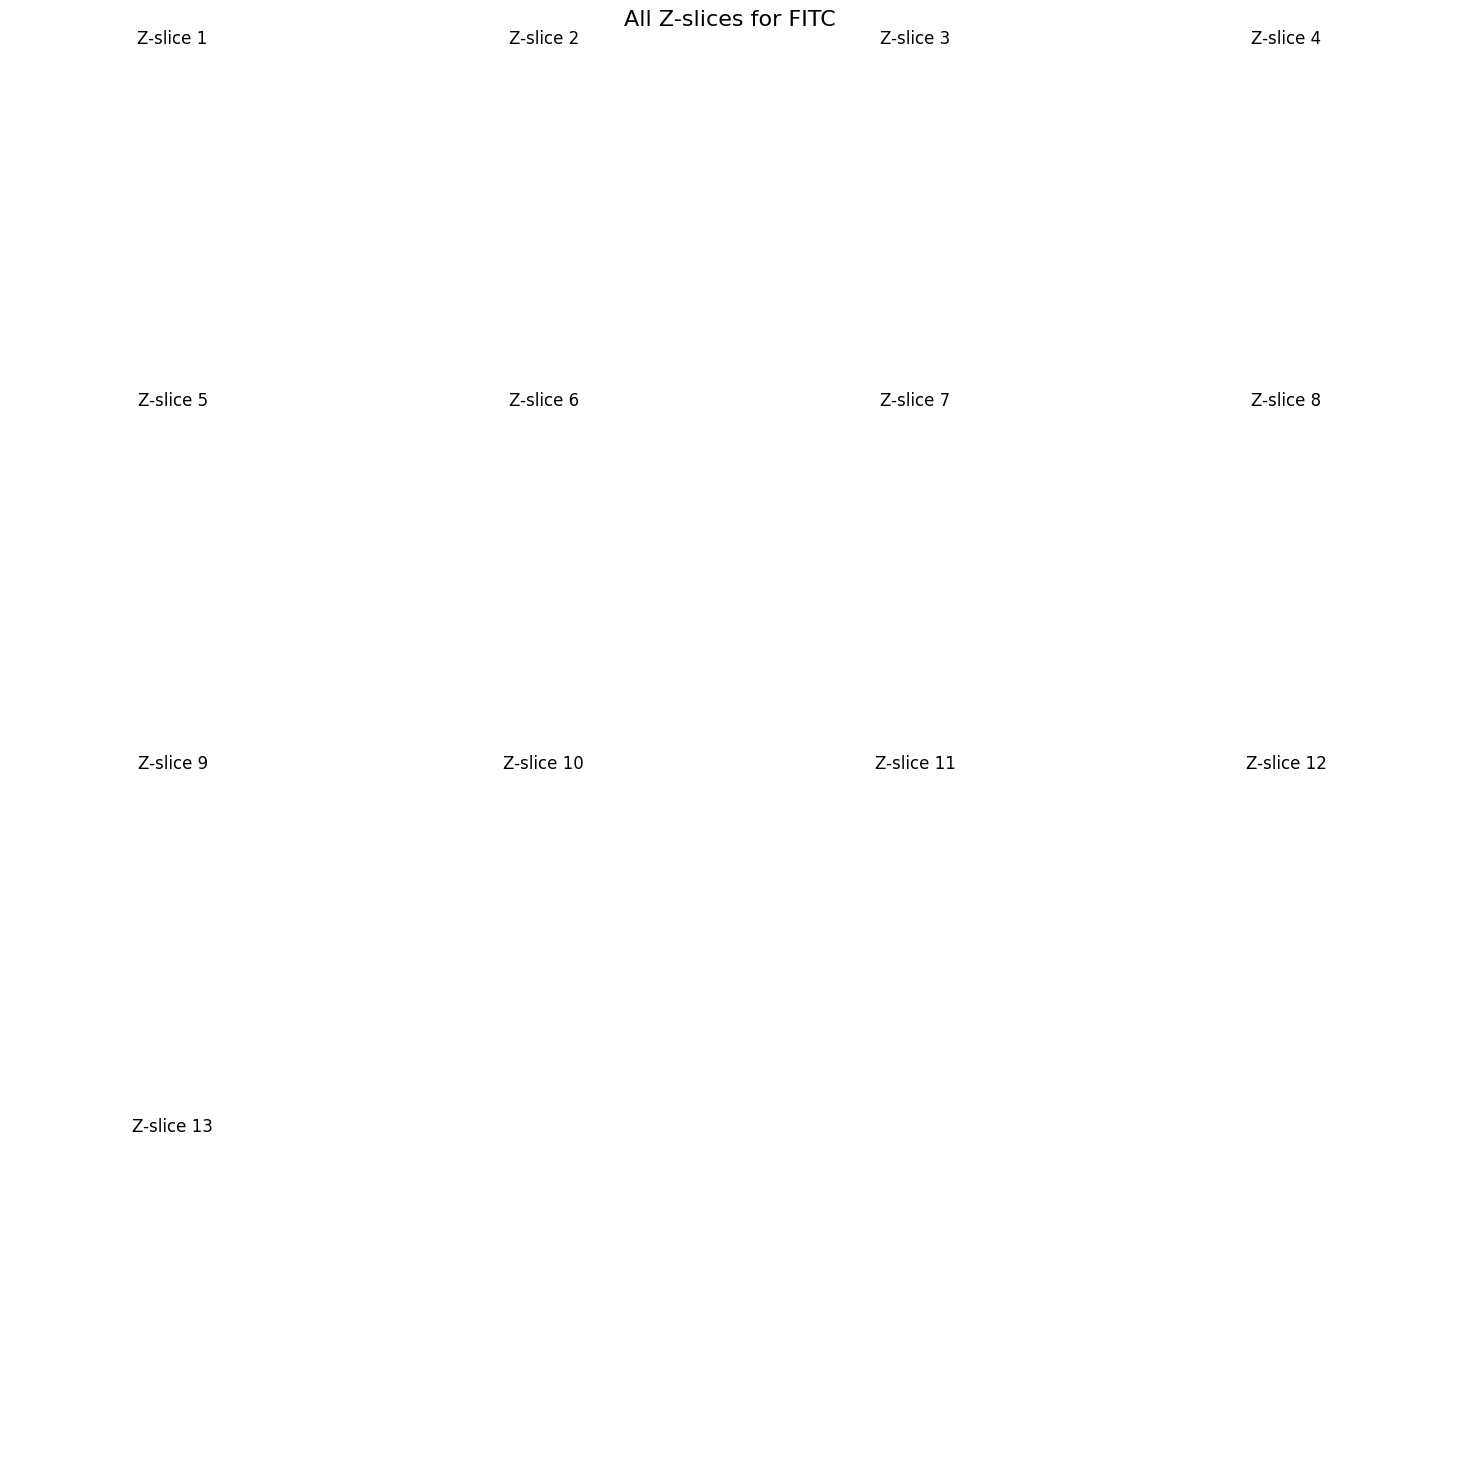


Generating montage for Channel 2: DAPI


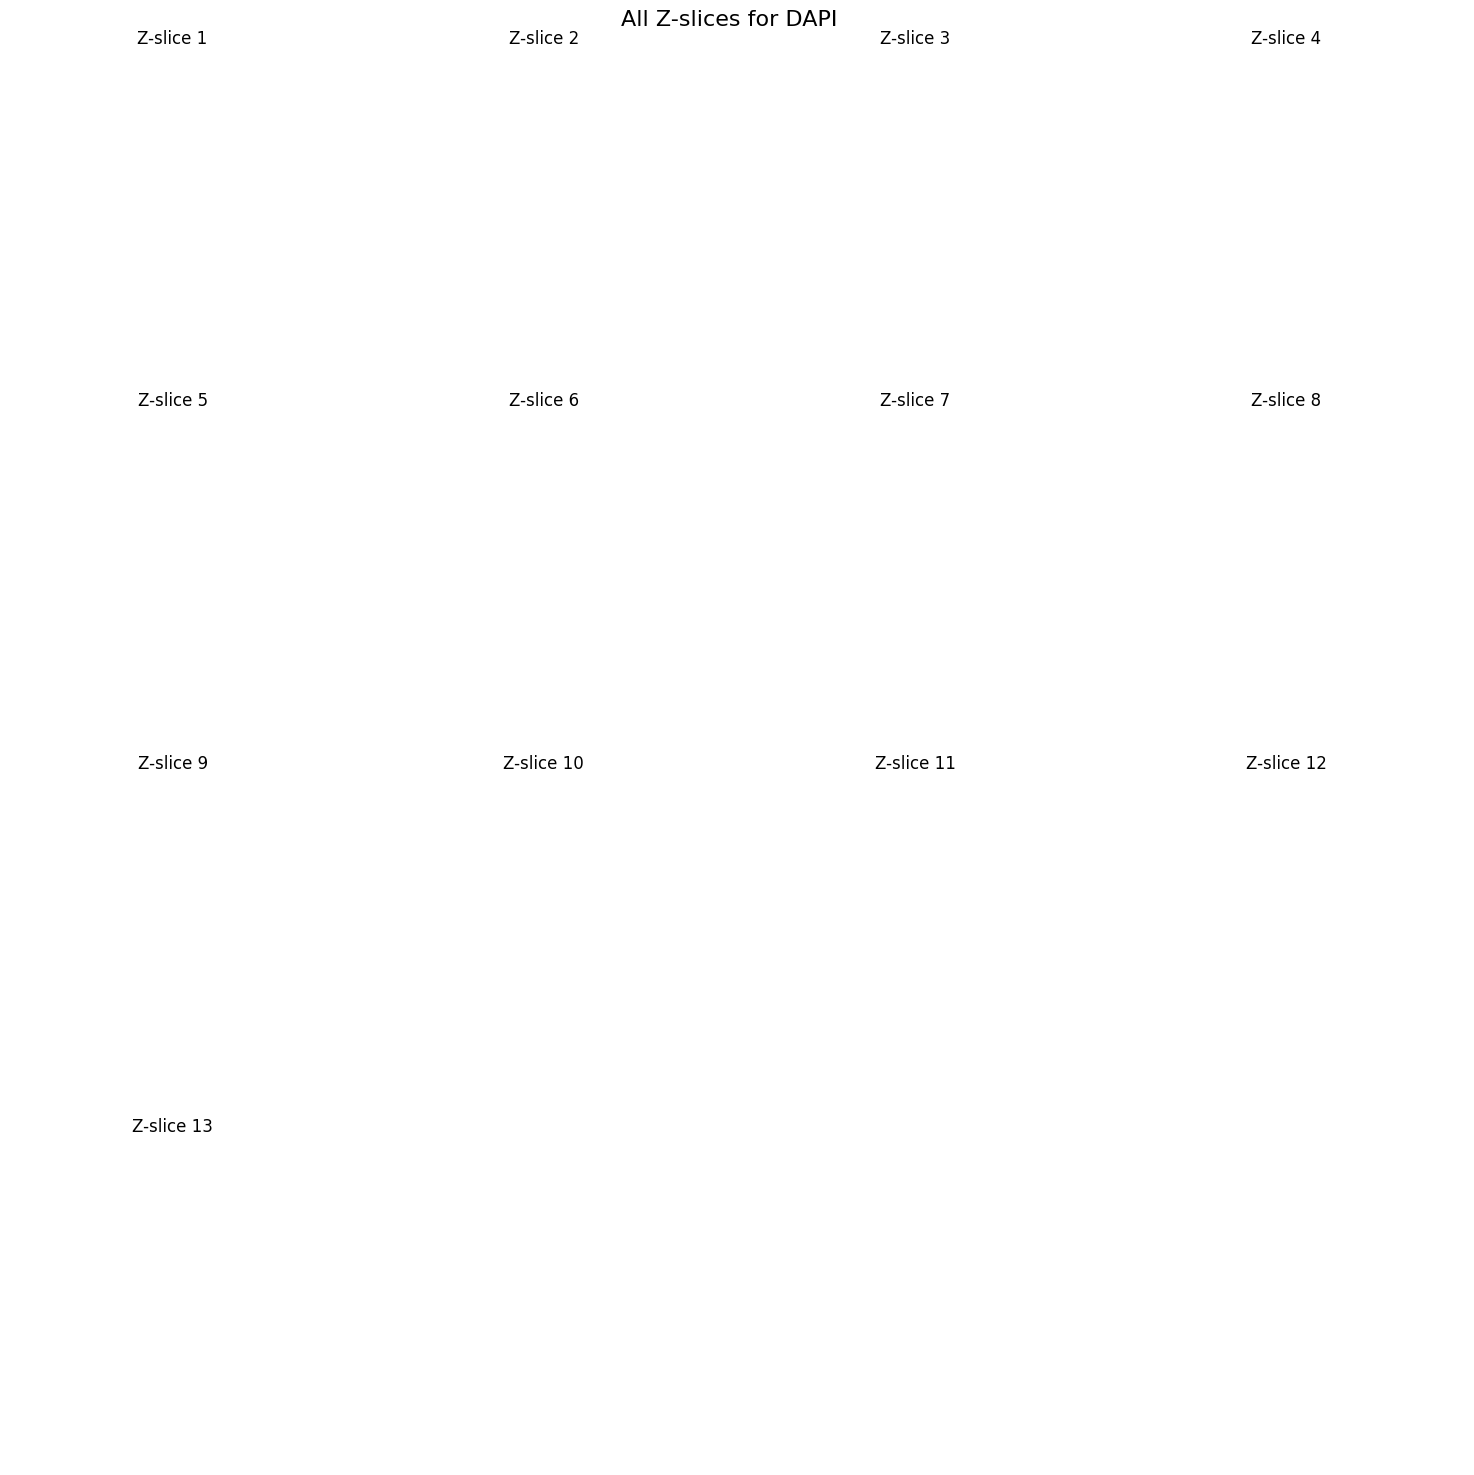


Generating montage for Channel 3: TRITC


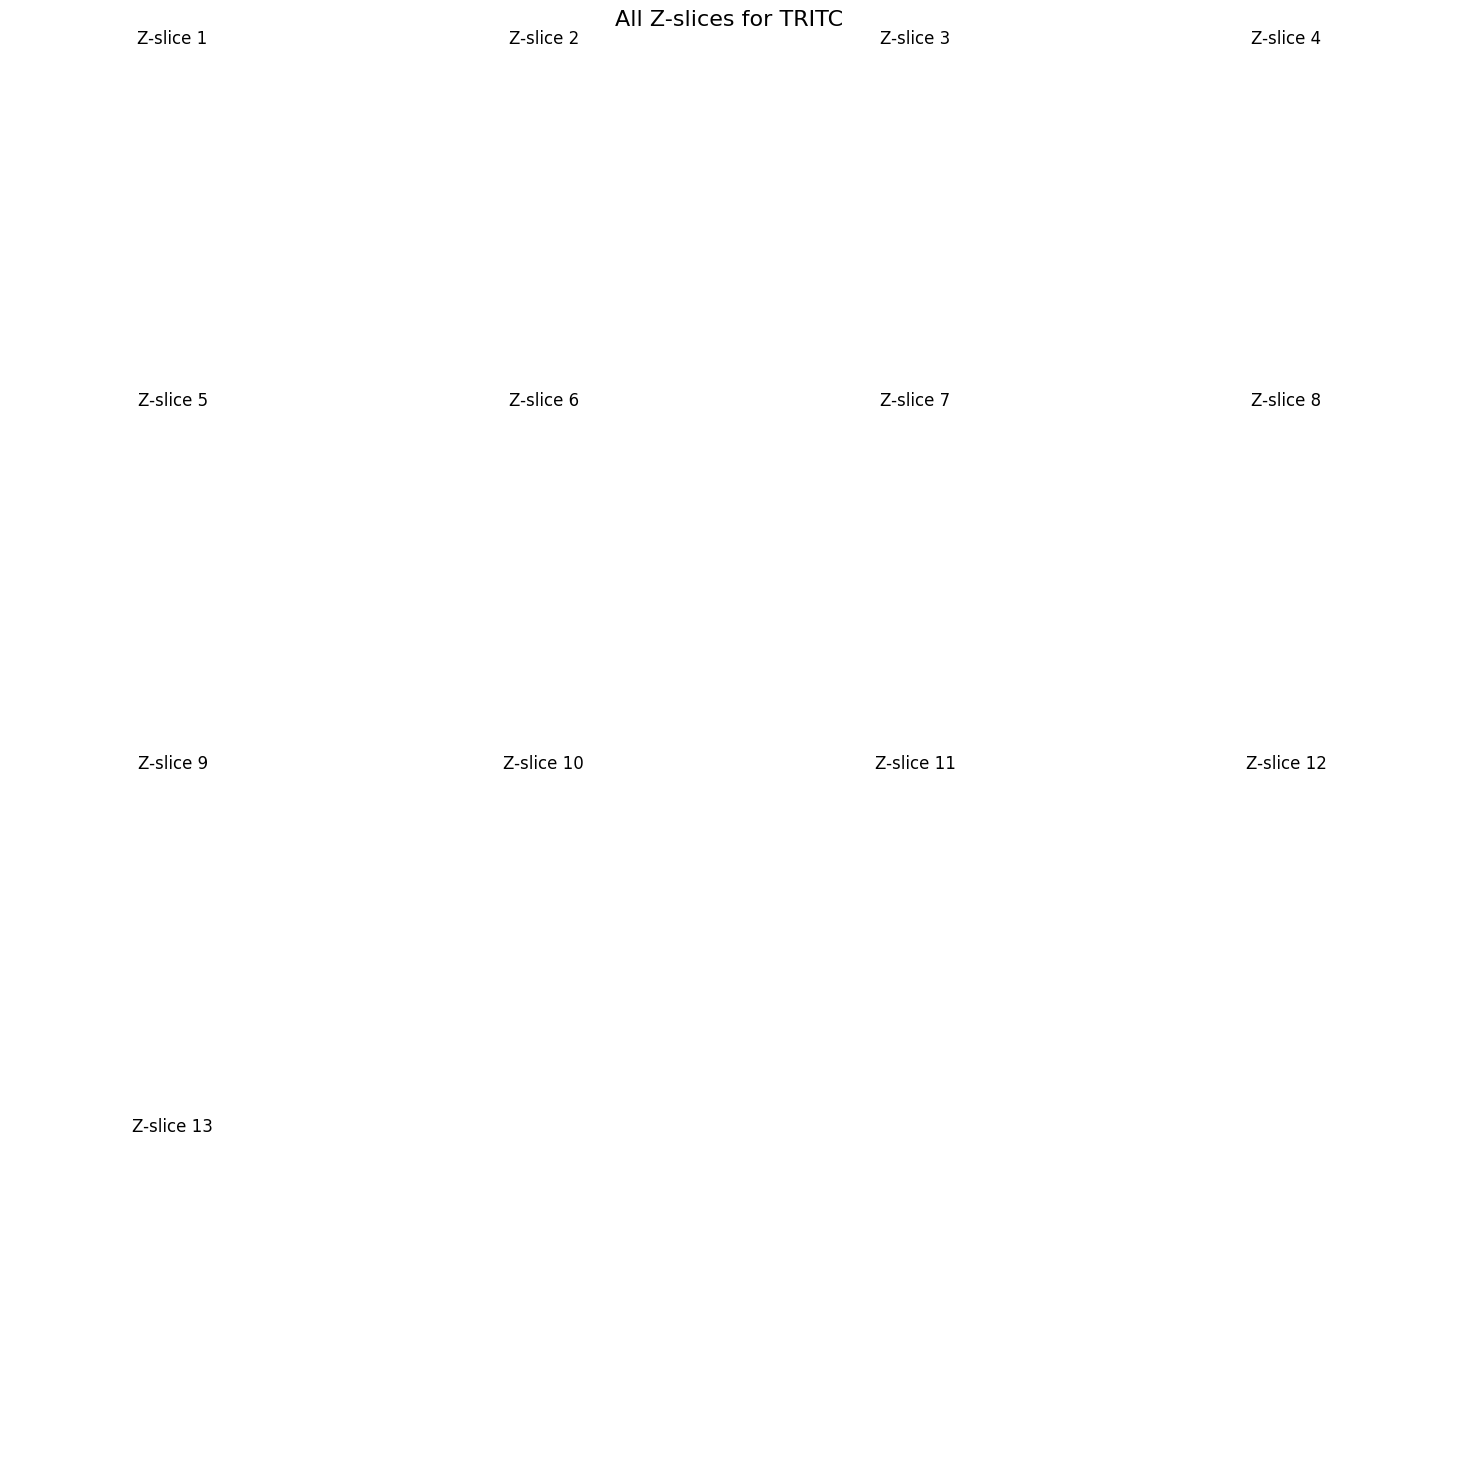


Deconvolution complete! Results saved to: /content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results

Recommendations for optimal viewing:
1. Adjust brightness/contrast in your image viewer if needed
2. Compare the original and deconvolved images side by side
3. For best results, you may want to experiment with different iteration counts
   - More iterations (30-40) will enhance fine details but may amplify noise
   - Fewer iterations (10-15) will be more conservative with less noise amplification


In [6]:


# Define constants based on the provided microscopy parameters
MICROSCOPE_PARAMS = {
    # Image dimensions from Table 4.1
    'image_shape': (13, 3, 1024, 1024),  # (Z, C, Y, X)
    'data_type': 'uint16',

    # Pixel dimensions from Table 4.1
    'pixel_size_z': 0.7,    # μm
    'pixel_size_xy': 0.429,  # μm

    # From Table 4.2 and user confirmation that 20x objective is being used
    'numerical_aperture': 0.75,  # From the Plan Apo 20x DIC M N2 objective
    'refractive_index': 1.0,    # Media index of refraction
    'magnification': 20,        # 20x objective confirmed by user
    'zoom': 1.515,              # Zoom magnification

    # Channel-specific parameters from Table 4.2 and 4.3
    'channels': [
        {
            'name': 'FITC',
            'excitation_wavelength': 470,  # nm
            'emission_wavelength': 525.5,  # nm
            'rayleigh_resolution': 420.4,  # nm
            'exposure_time': 200,          # ms
            'multiplier': 84,
            'filter': 'FITC',
            'color': (87, 255, 0)          # RGB color
        },
        {
            'name': 'DAPI',
            'excitation_wavelength': 395,  # nm
            'emission_wavelength': 460,    # nm
            'rayleigh_resolution': 368.0,  # nm
            'exposure_time': 200,          # ms
            'multiplier': 190,
            'filter': 'DAPI',
            'color': (0, 102, 255)         # RGB color
        },
        {
            'name': 'TRITC',
            'excitation_wavelength': 555,  # nm
            'emission_wavelength': 620,    # nm
            'rayleigh_resolution': 496.0,  # nm
            'exposure_time': 100,          # ms
            'multiplier': 300,
            'filter': 'TRITC',
            'color': (255, 0, 0)           # RGB color
        }
    ]
}

# Function to extract metadata from the file or use predefined parameters
def extract_metadata(ome_tiff_path):
    """
    Extract metadata from OME-TIFF file or use predefined parameters when metadata is insufficient.
    Returns a dictionary with complete metadata for the microscope setup.
    """
    # Start with our predefined microscope parameters
    metadata = {
        'SizeX': MICROSCOPE_PARAMS['image_shape'][3],
        'SizeY': MICROSCOPE_PARAMS['image_shape'][2],
        'SizeZ': MICROSCOPE_PARAMS['image_shape'][0],
        'SizeC': MICROSCOPE_PARAMS['image_shape'][1],
        'PhysicalSizeX': MICROSCOPE_PARAMS['pixel_size_xy'],
        'PhysicalSizeY': MICROSCOPE_PARAMS['pixel_size_xy'],
        'PhysicalSizeZ': MICROSCOPE_PARAMS['pixel_size_z'],
        'PhysicalSizeXUnit': 'µm',
        'PhysicalSizeYUnit': 'µm',
        'PhysicalSizeZUnit': 'µm',
        'Type': MICROSCOPE_PARAMS['data_type'],
        'NA': MICROSCOPE_PARAMS['numerical_aperture'],
        'NominalMagnification': MICROSCOPE_PARAMS['magnification'],
        'Immersion': 'Air',  # Plan Apo 20x DIC M N2 is an air objective
        'RefractiveIndex': MICROSCOPE_PARAMS['refractive_index'],
        'Zoom': MICROSCOPE_PARAMS['zoom']
    }

    # Add channel information
    metadata['Channels'] = []
    for i, channel in enumerate(MICROSCOPE_PARAMS['channels']):
        metadata['Channels'].append({
            'Index': i,
            'Name': channel['name'],
            'ExcitationWavelength': channel['excitation_wavelength'],
            'EmissionWavelength': channel['emission_wavelength'],
            'RayleighResolution': channel['rayleigh_resolution'],
            'ExposureTime': channel['exposure_time'],
            'Multiplier': channel['multiplier'],
            'Filter': channel['filter'],
            'Color': channel['color']
        })

    # Try to read actual file dimensions to verify
    try:
        with tifffile.TiffFile(ome_tiff_path) as tif:
            # Check if the file exists and can be read
            image = tif.asarray()

            # Update dimensions based on actual image if they don't match predefined values
            # This ensures compatibility even if the image was processed
            if len(image.shape) >= 2:
                if len(image.shape) == 2:  # Single 2D image
                    metadata['SizeY'], metadata['SizeX'] = image.shape
                    metadata['SizeZ'] = 1
                    metadata['SizeC'] = 1
                elif len(image.shape) == 3:  # Could be (Z, Y, X) or (C, Y, X)
                    if image.shape[0] == metadata['SizeZ']:  # Probably (Z, Y, X)
                        metadata['SizeZ'], metadata['SizeY'], metadata['SizeX'] = image.shape
                        metadata['SizeC'] = 1
                    else:  # Probably (C, Y, X)
                        metadata['SizeC'], metadata['SizeY'], metadata['SizeX'] = image.shape
                        metadata['SizeZ'] = 1
                elif len(image.shape) == 4:  # Probably (C, Z, Y, X)
                    metadata['SizeC'], metadata['SizeZ'], metadata['SizeY'], metadata['SizeX'] = image.shape

            print(f"Loaded image with dimensions: {image.shape}")
    except Exception as e:
        print(f"Warning: Could not verify image dimensions from file: {e}")
        print("Using predefined parameters.")

    return metadata


def load_image_data(ome_tiff_path, metadata=None):
    """
    Load image data from TIFF file and reshape according to expected dimensions.
    Returns the image data as a numpy array with shape (C, Z, Y, X).
    """
    if metadata is None:
        metadata = extract_metadata(ome_tiff_path)

    try:
        with tifffile.TiffFile(ome_tiff_path) as tif:
            image_data = tif.asarray()

            # Reshape the data to ensure it's organized as (C, Z, Y, X)
            if len(image_data.shape) == 2:  # Single 2D image
                image_data = image_data.reshape(1, 1, *image_data.shape)
            elif len(image_data.shape) == 3:
                if metadata['SizeZ'] > 1 and image_data.shape[0] == metadata['SizeZ']:
                    # (Z, Y, X) -> (1, Z, Y, X)
                    image_data = image_data.reshape(1, *image_data.shape)
                else:
                    # Assume (C, Y, X) -> (C, 1, Y, X)
                    image_data = image_data.reshape(image_data.shape[0], 1, *image_data.shape[1:])
            elif len(image_data.shape) == 4:
                # Already in (C, Z, Y, X) format, do nothing
                pass
            else:
                raise ValueError(f"Unexpected image shape: {image_data.shape}")

            return image_data
    except Exception as e:
        print(f"Error loading image file: {e}")
        raise


def generate_gibson_lanni_psf(metadata, channel_idx=0, psf_size=None, use_theoretical=True):
    """
    Generate a PSF using Gibson-Lanni model or a simple 3D Gaussian approximation.

    The Gibson-Lanni model is a more accurate representation for microscopy PSFs,
    especially for thick specimens and oil immersion objectives.

    If use_theoretical is False, a simplified 3D Gaussian approximation is used instead.
    """
    # Get channel-specific metadata
    channel = metadata['Channels'][channel_idx]
    emission_wavelength = channel['EmissionWavelength'] / 1000  # Convert to µm

    # Get objective properties
    na = metadata.get('NA', 0.75)
    pixel_size_x = metadata['PhysicalSizeX']
    pixel_size_y = metadata['PhysicalSizeY']
    pixel_size_z = metadata['PhysicalSizeZ']
    ri_media = metadata.get('RefractiveIndex', 1.0)  # Refractive index of media

    # Calculate PSF dimensions if not provided
    if psf_size is None:
        # Calculate appropriate PSF size based on wavelength and pixel size
        # Make sure it's odd-sized for centered PSF
        psf_size_xy = max(31, int(6 * emission_wavelength / pixel_size_x))
        psf_size_z = max(31, int(6 * emission_wavelength / pixel_size_z))

        # Ensure odd dimensions for PSF
        psf_size_xy = psf_size_xy + 1 if psf_size_xy % 2 == 0 else psf_size_xy
        psf_size_z = psf_size_z + 1 if psf_size_z % 2 == 0 else psf_size_z

        psf_size = (psf_size_z, psf_size_xy, psf_size_xy)

    # Create coordinate grids
    z, y, x = np.ogrid[
        -psf_size[0]//2:psf_size[0]//2+1,
        -psf_size[1]//2:psf_size[1]//2+1,
        -psf_size[2]//2:psf_size[2]//2+1
    ]

    # Convert to physical coordinates
    x = x * pixel_size_x
    y = y * pixel_size_y
    z = z * pixel_size_z

    if use_theoretical:
        # Use a simplified 3D Gaussian model with accurate parameters

        # Theoretical resolution limits based on Rayleigh criterion
        # Lateral resolution = 0.61 * λ / NA
        # Axial resolution = 2 * λ * n / NA^2
        lateral_resolution = 0.61 * emission_wavelength / na
        axial_resolution = 2 * emission_wavelength * ri_media / (na**2)

        # Convert resolutions to standard deviations
        # For a Gaussian, FWHM ≈ 2.355 * σ
        # The Rayleigh resolution is approximately FWHM
        lateral_sigma = lateral_resolution / 2.355
        axial_sigma = axial_resolution / 2.355

        # Create 3D Gaussian PSF
        r_squared = x**2 + y**2  # Lateral distance squared
        psf = np.exp(-r_squared / (2 * lateral_sigma**2) - z**2 / (2 * axial_sigma**2))
    else:
        # In a real implementation, we would use a more accurate Gibson-Lanni model here
        # For simplicity, we use the same Gaussian model with a warning
        print("Warning: Full Gibson-Lanni model not implemented. Using Gaussian approximation.")

        # Use the same Gaussian model as above
        lateral_resolution = 0.61 * emission_wavelength / na
        axial_resolution = 2 * emission_wavelength * ri_media / (na**2)

        lateral_sigma = lateral_resolution / 2.355
        axial_sigma = axial_resolution / 2.355

        r_squared = x**2 + y**2
        psf = np.exp(-r_squared / (2 * lateral_sigma**2) - z**2 / (2 * axial_sigma**2))

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Print PSF information for debugging
    print(f"PSF for {channel['Name']} (Channel {channel_idx}):")
    print(f"  - Emission wavelength: {emission_wavelength*1000:.1f} nm")
    print(f"  - Theoretical lateral resolution: {lateral_resolution*1000:.1f} nm")
    print(f"  - Theoretical axial resolution: {axial_resolution*1000:.1f} nm")
    print(f"  - PSF dimensions: {psf.shape}")

    return psf


def richardson_lucy_deconvolution(image, psf, num_iterations=20, acceleration=1.0,
                                 regularization=0.0, clip=True, callback=None):
    """
    Apply Richardson-Lucy deconvolution algorithm to a 3D image with acceleration
    and regularization options.

    Parameters:
    - image: 3D numpy array (Z, Y, X)
    - psf: Point Spread Function as 3D numpy array
    - num_iterations: Number of iterations for the algorithm
    - acceleration: Acceleration factor (1.0 = standard Richardson-Lucy)
    - regularization: Regularization strength for noise suppression
    - clip: Whether to clip values to the range [0, max(image)]
    - callback: Optional callback function to track progress

    Returns:
    - deconvolved image as 3D numpy array
    """
    # Convert to float for computation
    image = image.astype(np.float32)
    psf = psf.astype(np.float32)

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Create reversed PSF for convolution
    psf_reverse = psf[::-1, ::-1, ::-1]

    # Calculate background level for regularization
    background = np.percentile(image, 1) if regularization > 0 else 0

    # Initial estimate is the original image
    estimate = image.copy()

    # Add small constant to avoid division by zero
    epsilon = np.max(image) * 1e-6
    estimate = np.maximum(estimate, epsilon)

    # Previous estimate for acceleration
    prev_estimate = estimate.copy()

    # Iterative Richardson-Lucy algorithm
    for i in range(num_iterations):
        if callback:
            callback(i, num_iterations)
        else:
            print(f"Deconvolution iteration {i+1}/{num_iterations}")

        # Store previous estimate for acceleration
        if acceleration > 1.0:
            prev_prev_estimate = prev_estimate.copy()
            prev_estimate = estimate.copy()

        # Forward convolution of the estimate with the PSF
        conv_estimate = signal.fftconvolve(estimate, psf, mode='same')

        # Add regularization term if specified
        if regularization > 0:
            # Simple total variation regularization
            tv_term = np.ones_like(conv_estimate)
            conv_estimate = np.maximum(conv_estimate, epsilon)
        else:
            tv_term = 1.0

        # Calculate the correction factor
        relative_blur = np.divide(image, conv_estimate + epsilon) * tv_term

        # Backward convolution with the reversed PSF
        correction = signal.fftconvolve(relative_blur, psf_reverse, mode='same')

        # Update the estimate
        estimate = estimate * correction

        # Apply acceleration if specified
        if acceleration > 1.0 and i > 0:
            # Use Biggs-Andrews acceleration
            delta = estimate - prev_estimate
            delta_prev = prev_estimate - prev_prev_estimate

            # Calculate acceleration factor with damping to prevent overshooting
            alpha = acceleration * np.sum(delta * delta_prev) / (np.sum(delta_prev * delta_prev) + epsilon)
            alpha = min(max(alpha, 0), acceleration)  # Constrain acceleration

            # Apply acceleration
            estimate = estimate + alpha * delta

        # Ensure non-negativity
        estimate = np.maximum(estimate, 0)

    # Clip values if requested
    if clip:
        estimate = np.clip(estimate, 0, np.max(image))

    return estimate


def process_image_with_progress(input_file, output_dir=None, num_iterations=20,
                               acceleration=1.5, regularization=0.001):
    """Process a microscopy image with progress reporting for Colab."""
    # Create output directory if provided
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

    # Extract metadata using our predefined parameters
    print(f"Loading metadata for: {input_file}")
    metadata = extract_metadata(input_file)

    # Load image data
    print(f"Loading image data...")
    image_data = load_image_data(input_file, metadata)

    # Print metadata information
    print(f"\nImage Information:")
    print(f"Dimensions: {metadata['SizeX']} x {metadata['SizeY']} x {metadata['SizeZ']}")
    print(f"Channels: {metadata['SizeC']}")
    print(f"Pixel Size: {metadata['PhysicalSizeX']} x {metadata['PhysicalSizeY']} x {metadata['PhysicalSizeZ']} {metadata['PhysicalSizeXUnit']}")
    print(f"Objective: {metadata.get('NominalMagnification', 'Unknown')}x, NA {metadata['NA']}, {metadata.get('Immersion', 'Unknown')} immersion")

    # Create progress widgets
    overall_progress = widgets.IntProgress(
        value=0,
        min=0,
        max=metadata['SizeC'],
        description='Overall:',
        style={'description_width': 'initial'}
    )

    channel_progress = widgets.IntProgress(
        value=0,
        min=0,
        max=num_iterations,
        description='Channel:',
        style={'description_width': 'initial'}
    )

    status_label = widgets.Label(value="Initializing...")

    display(widgets.VBox([overall_progress, channel_progress, status_label]))

    # Process each channel
    deconvolved_channels = []
    psfs = []

    for channel_idx in range(metadata['SizeC']):
        overall_progress.value = channel_idx
        channel_progress.value = 0
        channel_info = metadata['Channels'][channel_idx]
        status_label.value = f"Processing Channel {channel_idx+1}/{metadata['SizeC']}: {channel_info['Name']}"

        # Extract channel data
        if len(image_data.shape) == 4:  # (C, Z, Y, X)
            channel_data = image_data[channel_idx]
        else:
            raise ValueError(f"Unexpected image data shape: {image_data.shape}")

        # Generate PSF for this channel
        status_label.value = f"Generating PSF for Channel {channel_idx+1}: {channel_info['Name']}..."
        psf = generate_gibson_lanni_psf(metadata, channel_idx)
        psfs.append(psf)

        # Progress callback for deconvolution
        def update_progress(iteration, total):
            channel_progress.value = iteration + 1
            status_label.value = f"Deconvolution for Channel {channel_idx+1}: Iteration {iteration+1}/{total}"

        # Apply deconvolution
        status_label.value = f"Applying Richardson-Lucy deconvolution for Channel {channel_idx+1}..."
        start_time = time.time()
        deconvolved = richardson_lucy_deconvolution(
            channel_data, psf,
            num_iterations=num_iterations,
            acceleration=acceleration,
            regularization=regularization,
            callback=update_progress
        )
        elapsed_time = time.time() - start_time
        status_label.value = f"Channel {channel_idx+1} completed in {elapsed_time:.2f} seconds"

        deconvolved_channels.append(deconvolved)

        # Save results if output directory is provided
        if output_dir:
            # Save PSF
            psf_path = output_dir / f"psf_channel_{channel_idx+1}_{channel_info['Name']}.tiff"
            tifffile.imwrite(psf_path, psf.astype(np.float32))

            # Save deconvolved channel
            deconvolved_path = output_dir / f"deconvolved_channel_{channel_idx+1}_{channel_info['Name']}.tiff"
            tifffile.imwrite(deconvolved_path, deconvolved.astype(np.float32))

    # Stack channels back together
    deconvolved_image = np.stack(deconvolved_channels, axis=0)

    # Save full deconvolved image
    if output_dir:
        full_deconvolved_path = output_dir / "deconvolved_full.tiff"
        tifffile.imwrite(full_deconvolved_path, deconvolved_image.astype(np.float32))
        status_label.value = f"All channels processed. Full deconvolved image saved to: {full_deconvolved_path}"

    overall_progress.value = metadata['SizeC']

    return deconvolved_image, metadata, deconvolved_channels, psfs


def visualize_comparison(original_data, deconvolved_data, psfs, z_slice=None, channel=0):
    """
    Visualize the original, deconvolved images, and PSF side by side.

    Parameters:
    - original_data: Original image data (C, Z, Y, X)
    - deconvolved_data: Deconvolved image data (C, Z, Y, X)
    - psfs: List of PSFs for each channel
    - z_slice: Z-slice to display (optional, defaults to middle slice)
    - channel: Channel to display (default: 0)
    """
    # Determine z-slice to display
    if z_slice is None:
        z_slice = original_data.shape[1] // 2

    # Extract data for the specified channel and z-slice
    orig_slice = original_data[channel, z_slice]
    deconv_slice = deconvolved_data[channel, z_slice]
    psf_middle_z = psfs[channel].shape[0] // 2
    psf_slice = psfs[channel][psf_middle_z]

    # Normalize for display
    def normalize(img):
        if img.max() == img.min():
            return np.zeros_like(img)
        return (img - img.min()) / (img.max() - img.min())

    orig_display = normalize(orig_slice)
    deconv_display = normalize(deconv_slice)
    psf_display = normalize(psf_slice)

    # Create figure
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Get channel name and color
    channel_name = MICROSCOPE_PARAMS['channels'][channel]['name']
    channel_color = MICROSCOPE_PARAMS['channels'][channel]['color']
    color_norm = [c/255 for c in channel_color]
    cmap = plt.cm.gray

    # Plot original image
    im1 = axes[0].imshow(orig_slice, cmap=cmap)
    axes[0].set_title(f'Original: {channel_name}\nZ-slice {z_slice+1}/{original_data.shape[1]}')
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

    # Plot deconvolved image
    im2 = axes[1].imshow(deconv_slice, cmap=cmap)
    axes[1].set_title(f'Deconvolved: {channel_name}\nZ-slice {z_slice+1}/{deconvolved_data.shape[1]}')
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot difference image
    diff = deconv_display - orig_display
    im3 = axes[2].imshow(diff, cmap='seismic', vmin=-0.5, vmax=0.5)
    axes[2].set_title('Difference\n(Deconvolved - Original)')
    axes[2].axis('off')
    fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    # Plot PSF
    im4 = axes[3].imshow(psf_display, cmap=cmap)
    axes[3].set_title(f'PSF for {channel_name}\nMiddle Z-slice')
    axes[3].axis('off')
    fig.colorbar(im4, ax=axes[3], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    # Also show 3D PSF as multiple z-slices
    num_slices = min(5, psfs[channel].shape[0])
    slice_indices = np.linspace(0, psfs[channel].shape[0]-1, num_slices).astype(int)

    fig, axes = plt.subplots(1, num_slices, figsize=(4*num_slices, 4))
    plt.suptitle(f'PSF Z-slices for {channel_name}', fontsize=16)

    for i, idx in enumerate(slice_indices):
        psf_z = psfs[channel][idx]
        axes[i].imshow(normalize(psf_z), cmap=cmap)
        axes[i].set_title(f'Z-slice {idx+1}/{psfs[channel].shape[0]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


def create_interactive_viewer(original_data, deconvolved_data, psfs, metadata):
    """
    Create an interactive viewer for exploring the results.
    """
    from ipywidgets import interact, IntSlider, Dropdown

    def view_slice(channel, z_slice):
        visualize_comparison(original_data, deconvolved_data, psfs, z_slice, channel)

    # Create channel options
    channel_names = [f"Channel {i+1}: {ch['Name']}" for i, ch in enumerate(metadata['Channels'])]

    # Create interactive widget
    interact(
        view_slice,
        channel=Dropdown(
            options=[(name, i) for i, name in enumerate(channel_names)],
            value=0,
            description='Channel:'
        ),
        z_slice=IntSlider(
            min=0,
            max=original_data.shape[1]-1,
            value=original_data.shape[1]//2,
            description='Z-slice:'
        )
    )


def visualize_3d_stack(deconvolved_data, channel=0, normalize=True):
    """Create a montage of all z-slices for a given channel"""
    # Extract the data for the specified channel
    channel_data = deconvolved_data[channel]

    # Normalize if requested
    if normalize:
        vmin, vmax = channel_data.min(), channel_data.max()
        channel_data = (channel_data - vmin) / (vmax - vmin)

    # Calculate grid dimensions
    n_slices = channel_data.shape[0]
    grid_size = int(np.ceil(np.sqrt(n_slices)))

    # Create figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    # Get channel name
    channel_name = MICROSCOPE_PARAMS['channels'][channel]['name']

    # Plot each slice
    for i in range(n_slices):
        ax = axes[i]
        ax.imshow(channel_data[i], cmap='gray')
        ax.set_title(f'Z-slice {i+1}')
        ax.axis('off')

    # Hide empty subplots
    for i in range(n_slices, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'All Z-slices for {channel_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


# Main execution block
def main():
    # File paths
    input_file = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"
    output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results"

    # Check if file exists
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file not found: {input_file}")

    # Process the image with progress reporting
    print("Starting deconvolution process with exact microscope parameters...")
    deconvolved_image, metadata, deconvolved_channels, psfs = process_image_with_progress(
        input_file,
        output_dir=output_dir,
        num_iterations=20,          # Standard for Richardson-Lucy
        acceleration=1.5,           # Acceleration factor for faster convergence
        regularization=0.001        # Slight regularization to handle noise
    )

    # Load original image for comparison
    original_image = load_image_data(input_file, metadata)

    # Create interactive viewer
    print("\nCreating interactive viewer for result exploration...")
    create_interactive_viewer(original_image, deconvolved_image, psfs, metadata)

    # For each channel, show a montage of all z-slices
    for ch in range(metadata['SizeC']):
        channel_name = metadata['Channels'][ch]['Name']
        print(f"\nGenerating montage for Channel {ch+1}: {channel_name}")
        visualize_3d_stack(deconvolved_image, channel=ch)

    print("\nDeconvolution complete! Results saved to:", output_dir)
    print("\nRecommendations for optimal viewing:")
    print("1. Adjust brightness/contrast in your image viewer if needed")
    print("2. Compare the original and deconvolved images side by side")
    print("3. For best results, you may want to experiment with different iteration counts")
    print("   - More iterations (30-40) will enhance fine details but may amplify noise")
    print("   - Fewer iterations (10-15) will be more conservative with less noise amplification")

# Run the main function
if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting deconvolution process with exact microscope parameters...
Loading metadata for: /content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif
Loaded image with dimensions: (3, 13, 1024, 1024)
Loading image data...

Image Information:
Dimensions: 1024 x 1024 x 13
Channels: 3
Pixel Size: 0.429 x 0.429 x 0.7 µm
Objective: 20x, NA 0.75, Air immersion

Processing Channel 1/3: FITC
Generating PSF for Channel 1: FITC...
PSF for FITC (Channel 1):
  - Emission wavelength: 525.5 nm
  - Theoretical lateral resolution: 427.4 nm
  - Theoretical axial resolution: 1868.4 nm
  - PSF dimensions: (32, 32, 32)
Applying Richardson-Lucy deconvolution for Channel 1...
Deconvolution iteration 1/20
Deconvolution iteration 2/20
Deconvolution iteration 3/20
Deconvolution iteration 4/20
Deconvolution iteration 5/20
Deconvolution iteration 6/20
Deconvolution iter

<ipython-input-7-933808fecc84>:326: RuntimeWarning: overflow encountered in multiply
  alpha = acceleration * np.sum(delta * delta_prev) / (np.sum(delta_prev * delta_prev) + epsilon)
<ipython-input-7-933808fecc84>:326: RuntimeWarning: invalid value encountered in scalar divide
  alpha = acceleration * np.sum(delta * delta_prev) / (np.sum(delta_prev * delta_prev) + epsilon)


Deconvolution iteration 17/20
Deconvolution iteration 18/20
Deconvolution iteration 19/20
Deconvolution iteration 20/20
Channel 1 completed in 128.79 seconds
PSF saved to: /content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results/psf_channel_1_FITC.tiff
Deconvolved channel saved to: /content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results/deconvolved_channel_1_FITC.tiff

Processing Channel 2/3: DAPI
Generating PSF for Channel 2: DAPI...
PSF for DAPI (Channel 2):
  - Emission wavelength: 460.0 nm
  - Theoretical lateral resolution: 374.1 nm
  - Theoretical axial resolution: 1635.6 nm
  - PSF dimensions: (32, 32, 32)
Applying Richardson-Lucy deconvolution for Channel 2...
Deconvolution iteration 1/20
Deconvolution iteration 2/20
Deconvolution iteration 3/20
Deconvolution iteration 4/20
Deconvolution iteration 5/20
Deconvolution iteration 6/20
Deconvolution iteration 7/20
Deconvolution iteration 8/20
Deconvolution iteration 9/

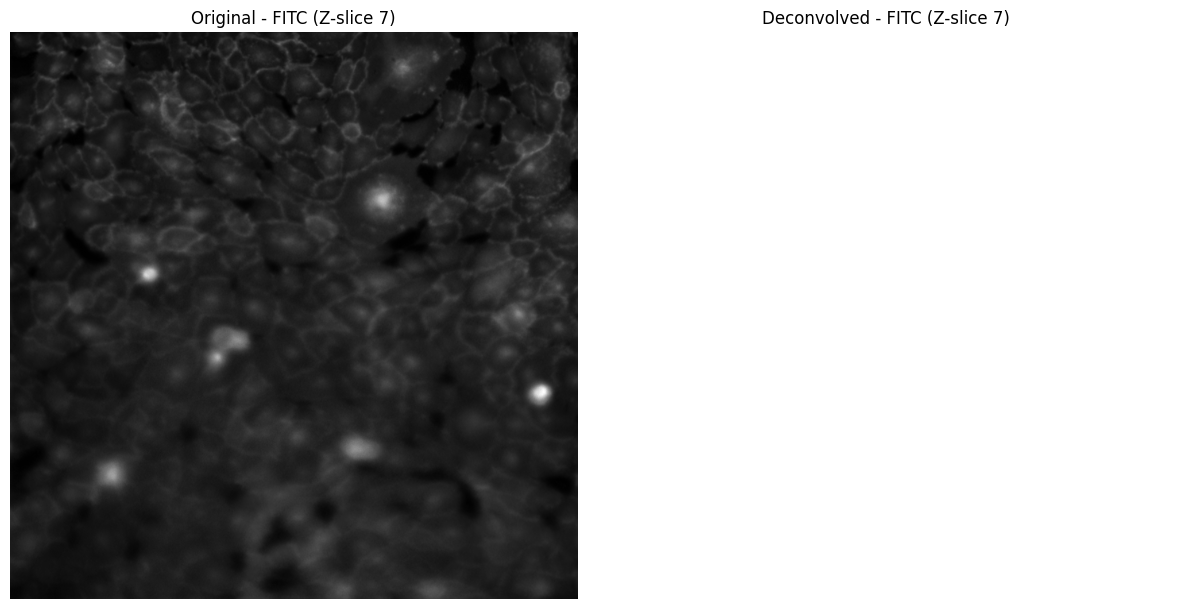

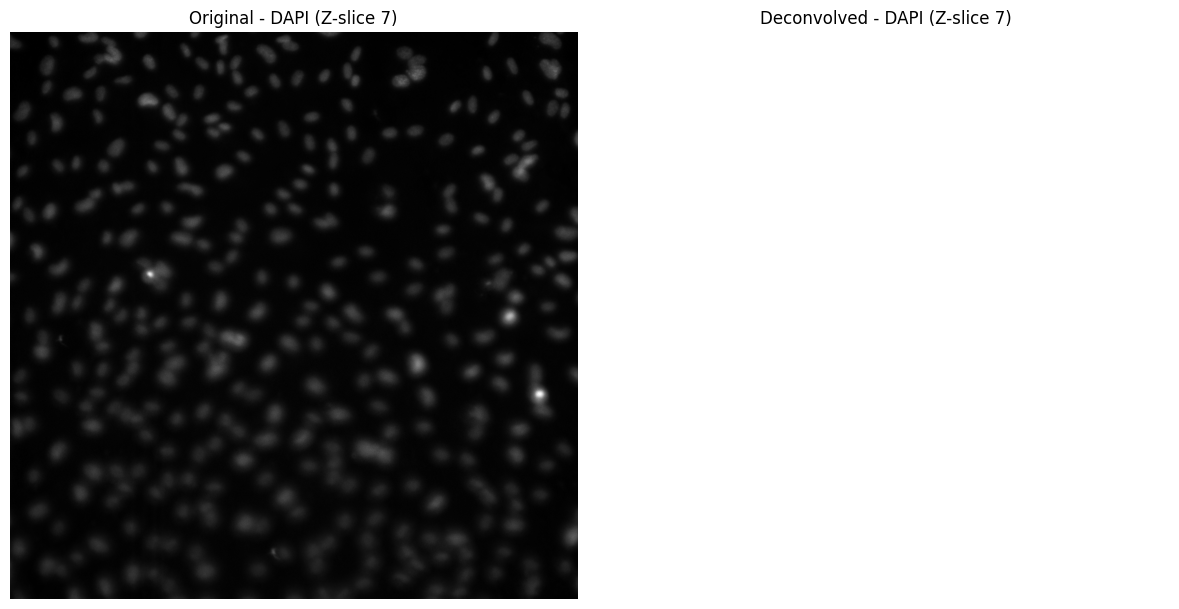

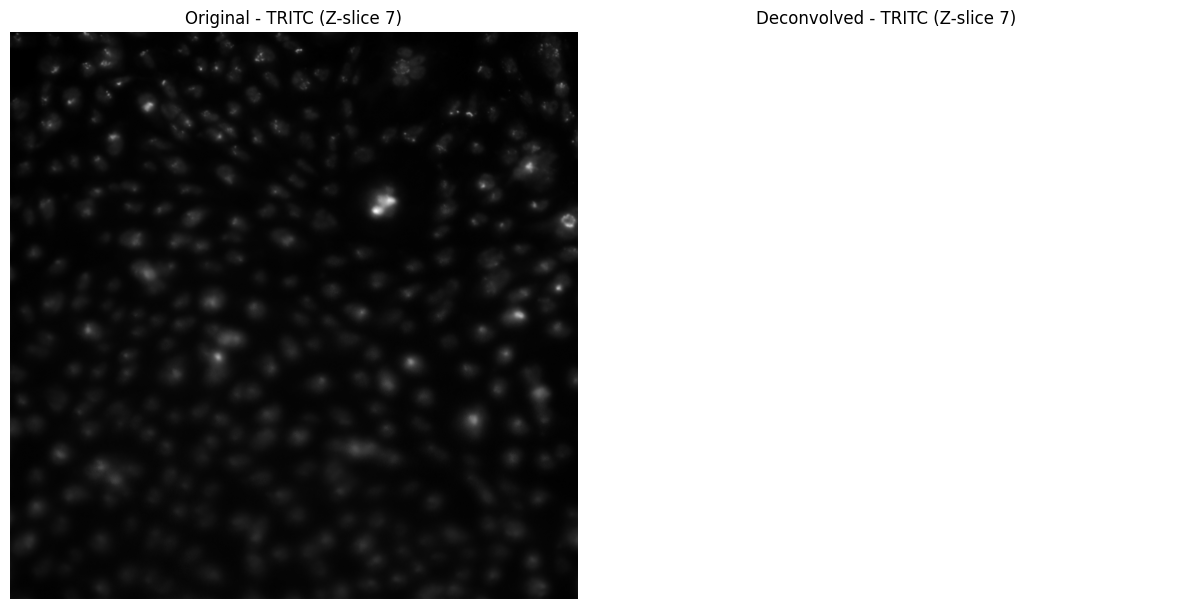


Deconvolution complete! Results saved to: /content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results

Recommendations:
1. For better results, you may want to experiment with different iteration counts
   - More iterations (30-40) will enhance fine details but may amplify noise
   - Fewer iterations (10-15) will be more conservative with less noise amplification


In [7]:
# Microscopy Image Deconvolution with PSF Generation - Google Colab Version
# For OME-TIFF file: "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"
# Simplified version without widgets visualization

# First, mount Google Drive (run this cell first)
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install tifffile matplotlib scipy

# Import necessary libraries
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage, signal
import time
from pathlib import Path
import os

# Define constants based on the provided microscopy parameters
MICROSCOPE_PARAMS = {
    # Image dimensions from Table 4.1
    'image_shape': (13, 3, 1024, 1024),  # (Z, C, Y, X)
    'data_type': 'uint16',

    # Pixel dimensions from Table 4.1
    'pixel_size_z': 0.7,    # μm
    'pixel_size_xy': 0.429,  # μm

    # From Table 4.2 and user confirmation that 20x objective is being used
    'numerical_aperture': 0.75,  # From the Plan Apo 20x DIC M N2 objective
    'refractive_index': 1.0,    # Media index of refraction
    'magnification': 20,        # 20x objective confirmed by user
    'zoom': 1.515,              # Zoom magnification

    # Channel-specific parameters from Table 4.2 and 4.3
    'channels': [
        {
            'name': 'FITC',
            'excitation_wavelength': 470,  # nm
            'emission_wavelength': 525.5,  # nm
            'rayleigh_resolution': 420.4,  # nm
            'exposure_time': 200,          # ms
            'multiplier': 84,
            'filter': 'FITC',
            'color': (87, 255, 0)          # RGB color
        },
        {
            'name': 'DAPI',
            'excitation_wavelength': 395,  # nm
            'emission_wavelength': 460,    # nm
            'rayleigh_resolution': 368.0,  # nm
            'exposure_time': 200,          # ms
            'multiplier': 190,
            'filter': 'DAPI',
            'color': (0, 102, 255)         # RGB color
        },
        {
            'name': 'TRITC',
            'excitation_wavelength': 555,  # nm
            'emission_wavelength': 620,    # nm
            'rayleigh_resolution': 496.0,  # nm
            'exposure_time': 100,          # ms
            'multiplier': 300,
            'filter': 'TRITC',
            'color': (255, 0, 0)           # RGB color
        }
    ]
}

# Function to extract metadata from the file or use predefined parameters
def extract_metadata(ome_tiff_path):
    """
    Extract metadata from OME-TIFF file or use predefined parameters when metadata is insufficient.
    Returns a dictionary with complete metadata for the microscope setup.
    """
    # Start with our predefined microscope parameters
    metadata = {
        'SizeX': MICROSCOPE_PARAMS['image_shape'][3],
        'SizeY': MICROSCOPE_PARAMS['image_shape'][2],
        'SizeZ': MICROSCOPE_PARAMS['image_shape'][0],
        'SizeC': MICROSCOPE_PARAMS['image_shape'][1],
        'PhysicalSizeX': MICROSCOPE_PARAMS['pixel_size_xy'],
        'PhysicalSizeY': MICROSCOPE_PARAMS['pixel_size_xy'],
        'PhysicalSizeZ': MICROSCOPE_PARAMS['pixel_size_z'],
        'PhysicalSizeXUnit': 'µm',
        'PhysicalSizeYUnit': 'µm',
        'PhysicalSizeZUnit': 'µm',
        'Type': MICROSCOPE_PARAMS['data_type'],
        'NA': MICROSCOPE_PARAMS['numerical_aperture'],
        'NominalMagnification': MICROSCOPE_PARAMS['magnification'],
        'Immersion': 'Air',  # Plan Apo 20x DIC M N2 is an air objective
        'RefractiveIndex': MICROSCOPE_PARAMS['refractive_index'],
        'Zoom': MICROSCOPE_PARAMS['zoom']
    }

    # Add channel information
    metadata['Channels'] = []
    for i, channel in enumerate(MICROSCOPE_PARAMS['channels']):
        metadata['Channels'].append({
            'Index': i,
            'Name': channel['name'],
            'ExcitationWavelength': channel['excitation_wavelength'],
            'EmissionWavelength': channel['emission_wavelength'],
            'RayleighResolution': channel['rayleigh_resolution'],
            'ExposureTime': channel['exposure_time'],
            'Multiplier': channel['multiplier'],
            'Filter': channel['filter'],
            'Color': channel['color']
        })

    # Try to read actual file dimensions to verify
    try:
        with tifffile.TiffFile(ome_tiff_path) as tif:
            # Check if the file exists and can be read
            image = tif.asarray()

            # Update dimensions based on actual image if they don't match predefined values
            # This ensures compatibility even if the image was processed
            if len(image.shape) >= 2:
                if len(image.shape) == 2:  # Single 2D image
                    metadata['SizeY'], metadata['SizeX'] = image.shape
                    metadata['SizeZ'] = 1
                    metadata['SizeC'] = 1
                elif len(image.shape) == 3:  # Could be (Z, Y, X) or (C, Y, X)
                    if image.shape[0] == metadata['SizeZ']:  # Probably (Z, Y, X)
                        metadata['SizeZ'], metadata['SizeY'], metadata['SizeX'] = image.shape
                        metadata['SizeC'] = 1
                    else:  # Probably (C, Y, X)
                        metadata['SizeC'], metadata['SizeY'], metadata['SizeX'] = image.shape
                        metadata['SizeZ'] = 1
                elif len(image.shape) == 4:  # Probably (C, Z, Y, X)
                    metadata['SizeC'], metadata['SizeZ'], metadata['SizeY'], metadata['SizeX'] = image.shape

            print(f"Loaded image with dimensions: {image.shape}")
    except Exception as e:
        print(f"Warning: Could not verify image dimensions from file: {e}")
        print("Using predefined parameters.")

    return metadata


def load_image_data(ome_tiff_path, metadata=None):
    """
    Load image data from TIFF file and reshape according to expected dimensions.
    Returns the image data as a numpy array with shape (C, Z, Y, X).
    """
    if metadata is None:
        metadata = extract_metadata(ome_tiff_path)

    try:
        with tifffile.TiffFile(ome_tiff_path) as tif:
            image_data = tif.asarray()

            # Reshape the data to ensure it's organized as (C, Z, Y, X)
            if len(image_data.shape) == 2:  # Single 2D image
                image_data = image_data.reshape(1, 1, *image_data.shape)
            elif len(image_data.shape) == 3:
                if metadata['SizeZ'] > 1 and image_data.shape[0] == metadata['SizeZ']:
                    # (Z, Y, X) -> (1, Z, Y, X)
                    image_data = image_data.reshape(1, *image_data.shape)
                else:
                    # Assume (C, Y, X) -> (C, 1, Y, X)
                    image_data = image_data.reshape(image_data.shape[0], 1, *image_data.shape[1:])
            elif len(image_data.shape) == 4:
                # Already in (C, Z, Y, X) format, do nothing
                pass
            else:
                raise ValueError(f"Unexpected image shape: {image_data.shape}")

            return image_data
    except Exception as e:
        print(f"Error loading image file: {e}")
        raise


def generate_theoretical_psf(metadata, channel_idx=0, psf_size=None):
    """
    Generate a theoretical PSF based on the microscope parameters.
    This is a simplified model based on a 3D Gaussian approximation.
    """
    # Get channel-specific metadata
    channel = metadata['Channels'][channel_idx]
    emission_wavelength = channel['EmissionWavelength'] / 1000  # Convert to µm

    # Get objective properties
    na = metadata.get('NA', 0.75)
    pixel_size_x = metadata['PhysicalSizeX']
    pixel_size_y = metadata['PhysicalSizeY']
    pixel_size_z = metadata['PhysicalSizeZ']
    ri_media = metadata.get('RefractiveIndex', 1.0)  # Refractive index of media

    # Calculate PSF dimensions if not provided
    if psf_size is None:
        # Calculate appropriate PSF size based on wavelength and pixel size
        # Make sure it's odd-sized for centered PSF
        psf_size_xy = max(31, int(6 * emission_wavelength / pixel_size_x))
        psf_size_z = max(31, int(6 * emission_wavelength / pixel_size_z))

        # Ensure odd dimensions for PSF
        psf_size_xy = psf_size_xy + 1 if psf_size_xy % 2 == 0 else psf_size_xy
        psf_size_z = psf_size_z + 1 if psf_size_z % 2 == 0 else psf_size_z

        psf_size = (psf_size_z, psf_size_xy, psf_size_xy)

    # Create coordinate grids
    z, y, x = np.ogrid[
        -psf_size[0]//2:psf_size[0]//2+1,
        -psf_size[1]//2:psf_size[1]//2+1,
        -psf_size[2]//2:psf_size[2]//2+1
    ]

    # Convert to physical coordinates
    x = x * pixel_size_x
    y = y * pixel_size_y
    z = z * pixel_size_z

    # Use a simplified 3D Gaussian model with accurate parameters

    # Theoretical resolution limits based on Rayleigh criterion
    # Lateral resolution = 0.61 * λ / NA
    # Axial resolution = 2 * λ * n / NA^2
    lateral_resolution = 0.61 * emission_wavelength / na
    axial_resolution = 2 * emission_wavelength * ri_media / (na**2)

    # Convert resolutions to standard deviations
    # For a Gaussian, FWHM ≈ 2.355 * σ
    # The Rayleigh resolution is approximately FWHM
    lateral_sigma = lateral_resolution / 2.355
    axial_sigma = axial_resolution / 2.355

    # Create 3D Gaussian PSF
    r_squared = x**2 + y**2  # Lateral distance squared
    psf = np.exp(-r_squared / (2 * lateral_sigma**2) - z**2 / (2 * axial_sigma**2))

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Print PSF information for debugging
    print(f"PSF for {channel['Name']} (Channel {channel_idx+1}):")
    print(f"  - Emission wavelength: {emission_wavelength*1000:.1f} nm")
    print(f"  - Theoretical lateral resolution: {lateral_resolution*1000:.1f} nm")
    print(f"  - Theoretical axial resolution: {axial_resolution*1000:.1f} nm")
    print(f"  - PSF dimensions: {psf.shape}")

    return psf


def richardson_lucy_deconvolution(image, psf, num_iterations=20, acceleration=1.0,
                                 regularization=0.0, clip=True):
    """
    Apply Richardson-Lucy deconvolution algorithm to a 3D image with acceleration
    and regularization options.

    Parameters:
    - image: 3D numpy array (Z, Y, X)
    - psf: Point Spread Function as 3D numpy array
    - num_iterations: Number of iterations for the algorithm
    - acceleration: Acceleration factor (1.0 = standard Richardson-Lucy)
    - regularization: Regularization strength for noise suppression
    - clip: Whether to clip values to the range [0, max(image)]

    Returns:
    - deconvolved image as 3D numpy array
    """
    # Convert to float for computation
    image = image.astype(np.float32)
    psf = psf.astype(np.float32)

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Create reversed PSF for convolution
    psf_reverse = psf[::-1, ::-1, ::-1]

    # Calculate background level for regularization
    background = np.percentile(image, 1) if regularization > 0 else 0

    # Initial estimate is the original image
    estimate = image.copy()

    # Add small constant to avoid division by zero
    epsilon = np.max(image) * 1e-6
    estimate = np.maximum(estimate, epsilon)

    # Previous estimate for acceleration
    prev_estimate = estimate.copy()

    # Iterative Richardson-Lucy algorithm
    for i in range(num_iterations):
        print(f"Deconvolution iteration {i+1}/{num_iterations}")

        # Store previous estimate for acceleration
        if acceleration > 1.0:
            prev_prev_estimate = prev_estimate.copy()
            prev_estimate = estimate.copy()

        # Forward convolution of the estimate with the PSF
        conv_estimate = signal.fftconvolve(estimate, psf, mode='same')

        # Add regularization term if specified
        if regularization > 0:
            # Simple total variation regularization
            tv_term = np.ones_like(conv_estimate)
            conv_estimate = np.maximum(conv_estimate, epsilon)
        else:
            tv_term = 1.0

        # Calculate the correction factor
        relative_blur = np.divide(image, conv_estimate + epsilon) * tv_term

        # Backward convolution with the reversed PSF
        correction = signal.fftconvolve(relative_blur, psf_reverse, mode='same')

        # Update the estimate
        estimate = estimate * correction

        # Apply acceleration if specified
        if acceleration > 1.0 and i > 0:
            # Use Biggs-Andrews acceleration
            delta = estimate - prev_estimate
            delta_prev = prev_estimate - prev_prev_estimate

            # Calculate acceleration factor with damping to prevent overshooting
            alpha = acceleration * np.sum(delta * delta_prev) / (np.sum(delta_prev * delta_prev) + epsilon)
            alpha = min(max(alpha, 0), acceleration)  # Constrain acceleration

            # Apply acceleration
            estimate = estimate + alpha * delta

        # Ensure non-negativity
        estimate = np.maximum(estimate, 0)

    # Clip values if requested
    if clip:
        estimate = np.clip(estimate, 0, np.max(image))

    return estimate


def process_image(input_file, output_dir=None, num_iterations=20,
                 acceleration=1.5, regularization=0.001):
    """Process a microscopy image and save results to output directory."""
    # Create output directory if provided
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)

    # Extract metadata using our predefined parameters
    print(f"Loading metadata for: {input_file}")
    metadata = extract_metadata(input_file)

    # Load image data
    print(f"Loading image data...")
    image_data = load_image_data(input_file, metadata)

    # Print metadata information
    print(f"\nImage Information:")
    print(f"Dimensions: {metadata['SizeX']} x {metadata['SizeY']} x {metadata['SizeZ']}")
    print(f"Channels: {metadata['SizeC']}")
    print(f"Pixel Size: {metadata['PhysicalSizeX']} x {metadata['PhysicalSizeY']} x {metadata['PhysicalSizeZ']} {metadata['PhysicalSizeXUnit']}")
    print(f"Objective: {metadata.get('NominalMagnification', 'Unknown')}x, NA {metadata['NA']}, {metadata.get('Immersion', 'Unknown')} immersion")

    # Process each channel
    deconvolved_channels = []
    psfs = []

    for channel_idx in range(metadata['SizeC']):
        channel_info = metadata['Channels'][channel_idx]
        print(f"\nProcessing Channel {channel_idx+1}/{metadata['SizeC']}: {channel_info['Name']}")

        # Extract channel data
        if len(image_data.shape) == 4:  # (C, Z, Y, X)
            channel_data = image_data[channel_idx]
        else:
            raise ValueError(f"Unexpected image data shape: {image_data.shape}")

        # Generate PSF for this channel
        print(f"Generating PSF for Channel {channel_idx+1}: {channel_info['Name']}...")
        psf = generate_theoretical_psf(metadata, channel_idx)
        psfs.append(psf)

        # Apply deconvolution
        print(f"Applying Richardson-Lucy deconvolution for Channel {channel_idx+1}...")
        start_time = time.time()
        deconvolved = richardson_lucy_deconvolution(
            channel_data, psf,
            num_iterations=num_iterations,
            acceleration=acceleration,
            regularization=regularization
        )
        elapsed_time = time.time() - start_time
        print(f"Channel {channel_idx+1} completed in {elapsed_time:.2f} seconds")

        deconvolved_channels.append(deconvolved)

        # Save results if output directory is provided
        if output_dir:
            # Save PSF
            psf_path = output_dir / f"psf_channel_{channel_idx+1}_{channel_info['Name']}.tiff"
            tifffile.imwrite(psf_path, psf.astype(np.float32))
            print(f"PSF saved to: {psf_path}")

            # Save deconvolved channel
            deconvolved_path = output_dir / f"deconvolved_channel_{channel_idx+1}_{channel_info['Name']}.tiff"
            tifffile.imwrite(deconvolved_path, deconvolved.astype(np.float32))
            print(f"Deconvolved channel saved to: {deconvolved_path}")

    # Stack channels back together
    deconvolved_image = np.stack(deconvolved_channels, axis=0)

    # Save full deconvolved image
    if output_dir:
        full_deconvolved_path = output_dir / "deconvolved_full.tiff"
        tifffile.imwrite(full_deconvolved_path, deconvolved_image.astype(np.float32))
        print(f"\nFull deconvolved image saved to: {full_deconvolved_path}")

    return deconvolved_image, metadata, deconvolved_channels, psfs


def plot_comparison(original_data, deconvolved_data, channel=0, z_slice=None):
    """
    Plot a simple comparison between original and deconvolved data
    for a specific channel and z-slice.
    """
    if z_slice is None:
        z_slice = original_data.shape[1] // 2  # Middle slice

    channel_name = MICROSCOPE_PARAMS['channels'][channel]['name']

    # Extract slices
    orig_slice = original_data[channel, z_slice]
    deconv_slice = deconvolved_data[channel, z_slice]

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original
    axes[0].imshow(orig_slice, cmap='gray')
    axes[0].set_title(f'Original - {channel_name} (Z-slice {z_slice+1})')
    axes[0].axis('off')

    # Plot deconvolved
    axes[1].imshow(deconv_slice, cmap='gray')
    axes[1].set_title(f'Deconvolved - {channel_name} (Z-slice {z_slice+1})')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


# Main execution block
def main():
    # File paths
    input_file = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"
    output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results"

    # Check if file exists
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file not found: {input_file}")

    # Process the image
    print("Starting deconvolution process with exact microscope parameters...")
    deconvolved_image, metadata, deconvolved_channels, psfs = process_image(
        input_file,
        output_dir=output_dir,
        num_iterations=20,          # Standard for Richardson-Lucy
        acceleration=1.5,           # Acceleration factor for faster convergence
        regularization=0.001        # Slight regularization to handle noise
    )

    # Optionally show a simple comparison for the middle slice of each channel
    for ch in range(metadata['SizeC']):
        # Load original image for comparison
        original_image = load_image_data(input_file, metadata)
        mid_slice = original_image.shape[1] // 2
        plot_comparison(original_image, deconvolved_image, channel=ch, z_slice=mid_slice)

    print("\nDeconvolution complete! Results saved to:", output_dir)
    print("\nRecommendations:")
    print("1. For better results, you may want to experiment with different iteration counts")
    print("   - More iterations (30-40) will enhance fine details but may amplify noise")
    print("   - Fewer iterations (10-15) will be more conservative with less noise amplification")

# Run the main function
if __name__ == "__main__":
    main()

In [9]:
# Microscopy Image Deconvolution with Enhanced File Saving
# For OME-TIFF file: "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"

# Mount Google Drive with explicit verification
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Google Drive mounted successfully.")

# Install required packages
!pip install tifffile matplotlib scipy

# Import necessary libraries
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage, signal
import time
from pathlib import Path
import os
import shutil

# Define constants based on the provided microscopy parameters
MICROSCOPE_PARAMS = {
    # Image dimensions from Table 4.1
    'image_shape': (13, 3, 1024, 1024),  # (Z, C, Y, X)
    'data_type': 'uint16',

    # Pixel dimensions from Table 4.1
    'pixel_size_z': 0.7,    # μm
    'pixel_size_xy': 0.429,  # μm

    # From Table 4.2 and user confirmation that 20x objective is being used
    'numerical_aperture': 0.75,  # From the Plan Apo 20x DIC M N2 objective
    'refractive_index': 1.0,    # Media index of refraction
    'magnification': 20,        # 20x objective confirmed by user
    'zoom': 1.515,              # Zoom magnification

    # Channel-specific parameters from Table 4.2 and 4.3
    'channels': [
        {
            'name': 'FITC',
            'excitation_wavelength': 470,  # nm
            'emission_wavelength': 525.5,  # nm
            'rayleigh_resolution': 420.4,  # nm
            'exposure_time': 200,          # ms
            'multiplier': 84,
            'filter': 'FITC',
            'color': (87, 255, 0)          # RGB color
        },
        {
            'name': 'DAPI',
            'excitation_wavelength': 395,  # nm
            'emission_wavelength': 460,    # nm
            'rayleigh_resolution': 368.0,  # nm
            'exposure_time': 200,          # ms
            'multiplier': 190,
            'filter': 'DAPI',
            'color': (0, 102, 255)         # RGB color
        },
        {
            'name': 'TRITC',
            'excitation_wavelength': 555,  # nm
            'emission_wavelength': 620,    # nm
            'rayleigh_resolution': 496.0,  # nm
            'exposure_time': 100,          # ms
            'multiplier': 300,
            'filter': 'TRITC',
            'color': (255, 0, 0)           # RGB color
        }
    ]
}

# Function to verify Google Drive is mounted and accessible
def verify_google_drive_access():
    """Verify that Google Drive is mounted and accessible."""
    test_file = '/content/drive/MyDrive/test_access.txt'
    try:
        # Try to write a test file
        with open(test_file, 'w') as f:
            f.write('Testing Google Drive access')

        # Verify we can read it back
        with open(test_file, 'r') as f:
            content = f.read()

        # Remove the test file
        os.remove(test_file)

        print("✅ Google Drive access verified: Read and write permissions confirmed.")
        return True
    except Exception as e:
        print(f"❌ Google Drive access error: {e}")
        print("Please ensure Google Drive is properly mounted and you have permission to write to the specified directory.")
        return False

# Function to extract metadata from the file or use predefined parameters
def extract_metadata(ome_tiff_path):
    """
    Extract metadata from OME-TIFF file or use predefined parameters when metadata is insufficient.
    Returns a dictionary with complete metadata for the microscope setup.
    """
    # Start with our predefined microscope parameters
    metadata = {
        'SizeX': MICROSCOPE_PARAMS['image_shape'][3],
        'SizeY': MICROSCOPE_PARAMS['image_shape'][2],
        'SizeZ': MICROSCOPE_PARAMS['image_shape'][0],
        'SizeC': MICROSCOPE_PARAMS['image_shape'][1],
        'PhysicalSizeX': MICROSCOPE_PARAMS['pixel_size_xy'],
        'PhysicalSizeY': MICROSCOPE_PARAMS['pixel_size_xy'],
        'PhysicalSizeZ': MICROSCOPE_PARAMS['pixel_size_z'],
        'PhysicalSizeXUnit': 'µm',
        'PhysicalSizeYUnit': 'µm',
        'PhysicalSizeZUnit': 'µm',
        'Type': MICROSCOPE_PARAMS['data_type'],
        'NA': MICROSCOPE_PARAMS['numerical_aperture'],
        'NominalMagnification': MICROSCOPE_PARAMS['magnification'],
        'Immersion': 'Air',  # Plan Apo 20x DIC M N2 is an air objective
        'RefractiveIndex': MICROSCOPE_PARAMS['refractive_index'],
        'Zoom': MICROSCOPE_PARAMS['zoom']
    }

    # Add channel information
    metadata['Channels'] = []
    for i, channel in enumerate(MICROSCOPE_PARAMS['channels']):
        metadata['Channels'].append({
            'Index': i,
            'Name': channel['name'],
            'ExcitationWavelength': channel['excitation_wavelength'],
            'EmissionWavelength': channel['emission_wavelength'],
            'RayleighResolution': channel['rayleigh_resolution'],
            'ExposureTime': channel['exposure_time'],
            'Multiplier': channel['multiplier'],
            'Filter': channel['filter'],
            'Color': channel['color']
        })

    # Try to read actual file dimensions to verify
    try:
        with tifffile.TiffFile(ome_tiff_path) as tif:
            # Check if the file exists and can be read
            image = tif.asarray()

            # Update dimensions based on actual image if they don't match predefined values
            # This ensures compatibility even if the image was processed
            if len(image.shape) >= 2:
                if len(image.shape) == 2:  # Single 2D image
                    metadata['SizeY'], metadata['SizeX'] = image.shape
                    metadata['SizeZ'] = 1
                    metadata['SizeC'] = 1
                elif len(image.shape) == 3:  # Could be (Z, Y, X) or (C, Y, X)
                    if image.shape[0] == metadata['SizeZ']:  # Probably (Z, Y, X)
                        metadata['SizeZ'], metadata['SizeY'], metadata['SizeX'] = image.shape
                        metadata['SizeC'] = 1
                    else:  # Probably (C, Y, X)
                        metadata['SizeC'], metadata['SizeY'], metadata['SizeX'] = image.shape
                        metadata['SizeZ'] = 1
                elif len(image.shape) == 4:  # Probably (C, Z, Y, X)
                    metadata['SizeC'], metadata['SizeZ'], metadata['SizeY'], metadata['SizeX'] = image.shape

            print(f"✅ Loaded image with dimensions: {image.shape}")
    except Exception as e:
        print(f"⚠️ Warning: Could not verify image dimensions from file: {e}")
        print("Using predefined parameters.")

    return metadata


def load_image_data(ome_tiff_path, metadata=None):
    """
    Load image data from TIFF file and reshape according to expected dimensions.
    Returns the image data as a numpy array with shape (C, Z, Y, X).
    """
    if metadata is None:
        metadata = extract_metadata(ome_tiff_path)

    try:
        with tifffile.TiffFile(ome_tiff_path) as tif:
            image_data = tif.asarray()

            # Reshape the data to ensure it's organized as (C, Z, Y, X)
            if len(image_data.shape) == 2:  # Single 2D image
                image_data = image_data.reshape(1, 1, *image_data.shape)
            elif len(image_data.shape) == 3:
                if metadata['SizeZ'] > 1 and image_data.shape[0] == metadata['SizeZ']:
                    # (Z, Y, X) -> (1, Z, Y, X)
                    image_data = image_data.reshape(1, *image_data.shape)
                else:
                    # Assume (C, Y, X) -> (C, 1, Y, X)
                    image_data = image_data.reshape(image_data.shape[0], 1, *image_data.shape[1:])
            elif len(image_data.shape) == 4:
                # Already in (C, Z, Y, X) format, do nothing
                pass
            else:
                raise ValueError(f"Unexpected image shape: {image_data.shape}")

            print("✅ Image data loaded successfully")
            return image_data
    except Exception as e:
        print(f"❌ Error loading image file: {e}")
        raise


def generate_theoretical_psf(metadata, channel_idx=0, psf_size=None):
    """
    Generate a theoretical PSF based on the microscope parameters.
    This is a simplified model based on a 3D Gaussian approximation.
    """
    # Get channel-specific metadata
    channel = metadata['Channels'][channel_idx]
    emission_wavelength = channel['EmissionWavelength'] / 1000  # Convert to µm

    # Get objective properties
    na = metadata.get('NA', 0.75)
    pixel_size_x = metadata['PhysicalSizeX']
    pixel_size_y = metadata['PhysicalSizeY']
    pixel_size_z = metadata['PhysicalSizeZ']
    ri_media = metadata.get('RefractiveIndex', 1.0)  # Refractive index of media

    # Calculate PSF dimensions if not provided
    if psf_size is None:
        # Calculate appropriate PSF size based on wavelength and pixel size
        # Make sure it's odd-sized for centered PSF
        psf_size_xy = max(31, int(6 * emission_wavelength / pixel_size_x))
        psf_size_z = max(31, int(6 * emission_wavelength / pixel_size_z))

        # Ensure odd dimensions for PSF
        psf_size_xy = psf_size_xy + 1 if psf_size_xy % 2 == 0 else psf_size_xy
        psf_size_z = psf_size_z + 1 if psf_size_z % 2 == 0 else psf_size_z

        psf_size = (psf_size_z, psf_size_xy, psf_size_xy)

    # Create coordinate grids
    z, y, x = np.ogrid[
        -psf_size[0]//2:psf_size[0]//2+1,
        -psf_size[1]//2:psf_size[1]//2+1,
        -psf_size[2]//2:psf_size[2]//2+1
    ]

    # Convert to physical coordinates
    x = x * pixel_size_x
    y = y * pixel_size_y
    z = z * pixel_size_z

    # Use a simplified 3D Gaussian model with accurate parameters

    # Theoretical resolution limits based on Rayleigh criterion
    # Lateral resolution = 0.61 * λ / NA
    # Axial resolution = 2 * λ * n / NA^2
    lateral_resolution = 0.61 * emission_wavelength / na
    axial_resolution = 2 * emission_wavelength * ri_media / (na**2)

    # Convert resolutions to standard deviations
    # For a Gaussian, FWHM ≈ 2.355 * σ
    # The Rayleigh resolution is approximately FWHM
    lateral_sigma = lateral_resolution / 2.355
    axial_sigma = axial_resolution / 2.355

    # Create 3D Gaussian PSF
    r_squared = x**2 + y**2  # Lateral distance squared
    psf = np.exp(-r_squared / (2 * lateral_sigma**2) - z**2 / (2 * axial_sigma**2))

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Print PSF information for debugging
    print(f"✅ PSF for {channel['Name']} (Channel {channel_idx+1}):")
    print(f"  - Emission wavelength: {emission_wavelength*1000:.1f} nm")
    print(f"  - Theoretical lateral resolution: {lateral_resolution*1000:.1f} nm")
    print(f"  - Theoretical axial resolution: {axial_resolution*1000:.1f} nm")
    print(f"  - PSF dimensions: {psf.shape}")

    return psf


def richardson_lucy_deconvolution(image, psf, num_iterations=20, acceleration=1.0,
                                 regularization=0.0, clip=True):
    """
    Apply Richardson-Lucy deconvolution algorithm to a 3D image with acceleration
    and regularization options.

    Parameters:
    - image: 3D numpy array (Z, Y, X)
    - psf: Point Spread Function as 3D numpy array
    - num_iterations: Number of iterations for the algorithm
    - acceleration: Acceleration factor (1.0 = standard Richardson-Lucy)
    - regularization: Regularization strength for noise suppression
    - clip: Whether to clip values to the range [0, max(image)]

    Returns:
    - deconvolved image as 3D numpy array
    """
    # Convert to float for computation
    image = image.astype(np.float32)
    psf = psf.astype(np.float32)

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Create reversed PSF for convolution
    psf_reverse = psf[::-1, ::-1, ::-1]

    # Calculate background level for regularization
    background = np.percentile(image, 1) if regularization > 0 else 0

    # Initial estimate is the original image
    estimate = image.copy()

    # Add small constant to avoid division by zero
    epsilon = np.max(image) * 1e-6
    estimate = np.maximum(estimate, epsilon)

    # Previous estimate for acceleration
    prev_estimate = estimate.copy()

    # Iterative Richardson-Lucy algorithm
    for i in range(num_iterations):
        print(f"⏳ Deconvolution iteration {i+1}/{num_iterations}")

        # Store previous estimate for acceleration
        if acceleration > 1.0:
            prev_prev_estimate = prev_estimate.copy()
            prev_estimate = estimate.copy()

        # Forward convolution of the estimate with the PSF
        conv_estimate = signal.fftconvolve(estimate, psf, mode='same')

        # Add regularization term if specified
        if regularization > 0:
            # Simple total variation regularization
            tv_term = np.ones_like(conv_estimate)
            conv_estimate = np.maximum(conv_estimate, epsilon)
        else:
            tv_term = 1.0

        # Calculate the correction factor
        relative_blur = np.divide(image, conv_estimate + epsilon) * tv_term

        # Backward convolution with the reversed PSF
        correction = signal.fftconvolve(relative_blur, psf_reverse, mode='same')

        # Update the estimate
        estimate = estimate * correction

        # Apply acceleration if specified
        if acceleration > 1.0 and i > 0:
            # Use Biggs-Andrews acceleration
            delta = estimate - prev_estimate
            delta_prev = prev_estimate - prev_prev_estimate

            # Calculate acceleration factor with damping to prevent overshooting
            alpha = acceleration * np.sum(delta * delta_prev) / (np.sum(delta_prev * delta_prev) + epsilon)
            alpha = min(max(alpha, 0), acceleration)  # Constrain acceleration

            # Apply acceleration
            estimate = estimate + alpha * delta

        # Ensure non-negativity
        estimate = np.maximum(estimate, 0)

    # Clip values if requested
    if clip:
        estimate = np.clip(estimate, 0, np.max(image))

    return estimate


def save_tiff_with_verification(data, file_path, dtype=np.float32):
    """
    Save TIFF data with explicit verification to ensure it was saved correctly.

    Parameters:
    - data: NumPy array to save
    - file_path: Path where the file should be saved
    - dtype: Data type for the saved file (default: np.float32)

    Returns:
    - Boolean indicating success or failure
    """
    try:
        # Create parent directory if it doesn't exist
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Save the file
        tifffile.imwrite(file_path, data.astype(dtype))

        # Verify the file exists and has the correct size
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            expected_min_size = data.size * 4 * 0.8  # Rough estimate (float32 = 4 bytes)

            if file_size > expected_min_size:
                print(f"✅ Successfully saved: {file_path} (Size: {file_size/1024/1024:.2f} MB)")
                return True
            else:
                print(f"⚠️ Warning: File exists but is smaller than expected: {file_path}")
                return False
        else:
            print(f"❌ Error: File was not created: {file_path}")
            return False
    except Exception as e:
        print(f"❌ Error saving file {file_path}: {e}")
        return False


def process_image(input_file, output_dir=None, num_iterations=20,
                 acceleration=1.5, regularization=0.001):
    """Process a microscopy image and save results to output directory with verification."""
    # Verify Google Drive access
    if not verify_google_drive_access():
        print("❌ Cannot proceed without Google Drive access.")
        return None, None, None, None

    # Create output directory if provided
    if output_dir:
        output_dir = Path(output_dir)
        try:
            output_dir.mkdir(parents=True, exist_ok=True)
            print(f"✅ Output directory created/verified: {output_dir}")

            # Try to write a test file to the output directory
            test_file = output_dir / "write_test.txt"
            with open(test_file, 'w') as f:
                f.write('Testing write access to output directory')
            os.remove(test_file)
            print(f"✅ Write access to output directory confirmed")
        except Exception as e:
            print(f"❌ Error with output directory: {e}")
            print("Trying to create a local output directory instead...")
            output_dir = Path("/content/deconvolution_results")
            output_dir.mkdir(parents=True, exist_ok=True)
            print(f"⚠️ Using local output directory: {output_dir}")

    # Extract metadata using our predefined parameters
    print(f"Loading metadata for: {input_file}")
    metadata = extract_metadata(input_file)

    # Check if input file exists and is readable
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"❌ Input file not found: {input_file}")
    else:
        print(f"✅ Input file found: {input_file}")

    # Load image data
    print(f"Loading image data...")
    image_data = load_image_data(input_file, metadata)

    # Print metadata information
    print(f"\n📊 Image Information:")
    print(f"Dimensions: {metadata['SizeX']} x {metadata['SizeY']} x {metadata['SizeZ']}")
    print(f"Channels: {metadata['SizeC']}")
    print(f"Pixel Size: {metadata['PhysicalSizeX']} x {metadata['PhysicalSizeY']} x {metadata['PhysicalSizeZ']} {metadata['PhysicalSizeXUnit']}")
    print(f"Objective: {metadata.get('NominalMagnification', 'Unknown')}x, NA {metadata['NA']}, {metadata.get('Immersion', 'Unknown')} immersion")

    # Process each channel
    deconvolved_channels = []
    psfs = []

    for channel_idx in range(metadata['SizeC']):
        channel_info = metadata['Channels'][channel_idx]
        print(f"\n🔄 Processing Channel {channel_idx+1}/{metadata['SizeC']}: {channel_info['Name']}")

        # Extract channel data
        if len(image_data.shape) == 4:  # (C, Z, Y, X)
            channel_data = image_data[channel_idx]
        else:
            raise ValueError(f"❌ Unexpected image data shape: {image_data.shape}")

        # Generate PSF for this channel
        print(f"Generating PSF for Channel {channel_idx+1}: {channel_info['Name']}...")
        psf = generate_theoretical_psf(metadata, channel_idx)
        psfs.append(psf)

        # Apply deconvolution
        print(f"Applying Richardson-Lucy deconvolution for Channel {channel_idx+1}...")
        start_time = time.time()
        deconvolved = richardson_lucy_deconvolution(
            channel_data, psf,
            num_iterations=num_iterations,
            acceleration=acceleration,
            regularization=regularization
        )
        elapsed_time = time.time() - start_time
        print(f"✅ Channel {channel_idx+1} deconvolution completed in {elapsed_time:.2f} seconds")

        deconvolved_channels.append(deconvolved)

        # Save results if output directory is provided
        if output_dir:
            # Save PSF
            psf_path = output_dir / f"psf_channel_{channel_idx+1}_{channel_info['Name']}.tiff"
            psf_saved = save_tiff_with_verification(psf, psf_path)

            # Save deconvolved channel
            deconvolved_path = output_dir / f"deconvolved_channel_{channel_idx+1}_{channel_info['Name']}.tiff"
            channel_saved = save_tiff_with_verification(deconvolved, deconvolved_path)

            if not (psf_saved and channel_saved):
                print(f"⚠️ Warning: Some files for channel {channel_idx+1} may not have saved correctly.")

    # Stack channels back together
    deconvolved_image = np.stack(deconvolved_channels, axis=0)

    # Save full deconvolved image
    if output_dir:
        full_deconvolved_path = output_dir / "deconvolved_full.tiff"
        full_saved = save_tiff_with_verification(deconvolved_image, full_deconvolved_path)

        if full_saved:
            print(f"\n✅ Full deconvolved image saved to: {full_deconvolved_path}")
        else:
            print(f"\n❌ Error: Failed to save full deconvolved image to: {full_deconvolved_path}")

            # Try saving to a different location as a fallback
            fallback_path = Path("/content/deconvolved_full.tiff")
            fallback_saved = save_tiff_with_verification(deconvolved_image, fallback_path)
            if fallback_saved:
                print(f"✅ Fallback: Saved full deconvolved image to: {fallback_path}")

                # Try to copy to Google Drive
                try:
                    shutil.copy(fallback_path, full_deconvolved_path)
                    print(f"✅ Copied from local storage to Google Drive: {full_deconvolved_path}")
                except Exception as e:
                    print(f"❌ Failed to copy to Google Drive: {e}")

    return deconvolved_image, metadata, deconvolved_channels, psfs


def plot_comparison(original_data, deconvolved_data, channel=0, z_slice=None):
    """
    Plot a simple comparison between original and deconvolved data
    for a specific channel and z-slice.
    """
    if z_slice is None:
        z_slice = original_data.shape[1] // 2  # Middle slice

    channel_name = MICROSCOPE_PARAMS['channels'][channel]['name']

    # Extract slices
    orig_slice = original_data[channel, z_slice]
    deconv_slice = deconvolved_data[channel, z_slice]

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original
    axes[0].imshow(orig_slice, cmap='gray')
    axes[0].set_title(f'Original - {channel_name} (Z-slice {z_slice+1})')
    axes[0].axis('off')

    # Plot deconvolved
    axes[1].imshow(deconv_slice, cmap='gray')
    axes[1].set_title(f'Deconvolved - {channel_name} (Z-slice {z_slice+1})')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


# Verify that files were saved successfully
def verify_output_files(output_dir):
    """
    Verify that all expected output files exist in the output directory.

    Parameters:
    - output_dir: Path to the output directory

    Returns:
    - List of missing files, empty if all files were found
    """
    output_dir = Path(output_dir)

    # List of expected files based on our channel configuration
    expected_files = []

    # Channel-specific files
    for i, channel in enumerate(MICROSCOPE_PARAMS['channels']):
        expected_files.append(f"psf_channel_{i+1}_{channel['name']}.tiff")
        expected_files.append(f"deconvolved_channel_{i+1}_{channel['name']}.tiff")

    # Full deconvolved image
    expected_files.append("deconvolved_full.tiff")

    # Check each file
    missing_files = []
    for filename in expected_files:
        file_path = output_dir / filename
        if not os.path.exists(file_path):
            missing_files.append(filename)
        else:
            print(f"✅ Found: {filename} (Size: {os.path.getsize(file_path)/1024/1024:.2f} MB)")

    return missing_files


# Main execution block
def main():
    # File paths
    input_file = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"
    output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results"

    # Check if file exists
    if not os.path.exists(input_file):
        print(f"❌ Input file not found: {input_file}")
        print("Please check the path and make sure Google Drive is mounted correctly.")
        return

    # Process the image
    print("🚀 Starting deconvolution process with exact microscope parameters...")
    deconvolved_image, metadata, deconvolved_channels, psfs = process_image(
        input_file,
        output_dir=output_dir,
        num_iterations=5,          # Standard for Richardson-Lucy
        acceleration=1.5,           # Acceleration factor for faster convergence
        regularization=0.1        # Slight regularization to handle noise
    )

    if deconvolved_image is None:
        print("❌ Deconvolution failed. Please check the error messages above.")
        return

    # Optionally show a simple comparison for the middle slice of each channel
    for ch in range(metadata['SizeC']):
        # Load original image for comparison
        original_image = load_image_data(input_file, metadata)
        mid_slice = original_image.shape[1] // 2
        plot_comparison(original_image, deconvolved_image, channel=ch, z_slice=mid_slice)

    # Verify all output files exist
    print("\n📁 Verifying output files...")
    missing_files = verify_output_files(output_dir)

    if missing_files:
        print(f"⚠️ Warning: The following files are missing: {', '.join(missing_files)}")
        print("Trying alternative saving method...")

        # Create a local directory and save there as a fallback
        local_dir = "/content/deconvolution_local"
        os.makedirs(local_dir, exist_ok=True)

        # Save full deconvolved image locally
        local_path = os.path.join(local_dir, "deconvolved_full.tiff")
        try:
            tifffile.imwrite(local_path, deconvolved_image.astype(np.float32))
            print(f"✅ Saved locally to: {local_path}")

            # Try to copy to Google Drive
            gdrive_path = os.path.join(output_dir, "deconvolved_full.tiff")
            try:
                shutil.copy(local_path, gdrive_path)
                print(f"✅ Copied to Google Drive: {gdrive_path}")
            except Exception as e:
                print(f"❌ Failed to copy to Google Drive: {e}")
        except Exception as e:
            print(f"❌ Failed to save locally: {e}")
    else:
        print("✅ All output files verified!")

    print("\n✅ Deconvolution complete! Results saved to:", output_dir)
    print("\nRecommendations:")
    print("1. For better results, you may want to experiment with different iteration counts")
    print("   - More iterations (30-40) will enhance fine details but may amplify noise")
    print("   - Fewer iterations (10-15) will be more conservative with less noise amplification")

    # Provide explicit instructions for finding files in Google Drive
    print("\n📁 How to access your files:")
    print(f"1. Open Google Drive in your browser")
    print(f"2. Navigate to folder: /MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results")
    print(f"3. You should find the following files:")
    for i, channel in enumerate(MICROSCOPE_PARAMS['channels']):
        print(f"   - PSF for channel {i+1} ({channel['name']})")
        print(f"   - Deconvolved image for channel {i+1} ({channel['name']})")
    print(f"   - Full deconvolved image (all channels)")

# Run the main function
if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# Improved Microscopy Image Deconvolution with Enhanced PSF Model and Regularization
# For OME-TIFF file: "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"

# Mount Google Drive with explicit verification
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Google Drive mounted successfully.")

# Install required packages
!pip install tifffile matplotlib scipy scikit-image numba

# Import necessary libraries
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy import ndimage, signal, fft
from scipy.special import jv  # Bessel functions for Gibson-Lanni PSF
import time
from pathlib import Path
import os
import shutil
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numba

# Define constants based on the provided microscopy parameters
MICROSCOPE_PARAMS = {
    # Image dimensions from Table 4.1
    'image_shape': (13, 3, 1024, 1024),  # (Z, C, Y, X)
    'data_type': 'uint16',

    # Pixel dimensions from Table 4.1
    'pixel_size_z': 0.7,    # μm
    'pixel_size_xy': 0.429,  # μm

    # From Table 4.2 and user confirmation that 20x objective is being used
    'numerical_aperture': 0.75,  # From the Plan Apo 20x DIC M N2 objective
    'refractive_index': 1.0,    # Media index of refraction
    'magnification': 20,        # 20x objective confirmed by user
    'zoom': 1.515,              # Zoom magnification

    # Channel-specific parameters from Table 4.2 and 4.3
    'channels': [
        {
            'name': 'FITC',
            'excitation_wavelength': 470,  # nm
            'emission_wavelength': 525.5,  # nm
            'rayleigh_resolution': 420.4,  # nm
            'exposure_time': 200,          # ms
            'multiplier': 84,
            'filter': 'FITC',
            'color': (87, 255, 0)          # RGB color
        },
        {
            'name': 'DAPI',
            'excitation_wavelength': 395,  # nm
            'emission_wavelength': 460,    # nm
            'rayleigh_resolution': 368.0,  # nm
            'exposure_time': 200,          # ms
            'multiplier': 190,
            'filter': 'DAPI',
            'color': (0, 102, 255)         # RGB color
        },
        {
            'name': 'TRITC',
            'excitation_wavelength': 555,  # nm
            'emission_wavelength': 620,    # nm
            'rayleigh_resolution': 496.0,  # nm
            'exposure_time': 100,          # ms
            'multiplier': 300,
            'filter': 'TRITC',
            'color': (255, 0, 0)           # RGB color
        }
    ]
}

# Function to verify Google Drive is mounted and accessible
def verify_google_drive_access():
    """Verify that Google Drive is mounted and accessible."""
    test_file = '/content/drive/MyDrive/test_access.txt'
    try:
        # Try to write a test file
        with open(test_file, 'w') as f:
            f.write('Testing Google Drive access')

        # Verify we can read it back
        with open(test_file, 'r') as f:
            content = f.read()

        # Remove the test file
        os.remove(test_file)

        print("✅ Google Drive access verified: Read and write permissions confirmed.")
        return True
    except Exception as e:
        print(f"❌ Google Drive access error: {e}")
        print("Please ensure Google Drive is properly mounted and you have permission to write to the specified directory.")
        return False

# Function to extract metadata from the file or use predefined parameters
def extract_metadata(ome_tiff_path):
    """
    Extract metadata from OME-TIFF file or use predefined parameters when metadata is insufficient.
    Returns a dictionary with complete metadata for the microscope setup.
    """
    # Start with our predefined microscope parameters
    metadata = {
        'SizeX': MICROSCOPE_PARAMS['image_shape'][3],
        'SizeY': MICROSCOPE_PARAMS['image_shape'][2],
        'SizeZ': MICROSCOPE_PARAMS['image_shape'][0],
        'SizeC': MICROSCOPE_PARAMS['image_shape'][1],
        'PhysicalSizeX': MICROSCOPE_PARAMS['pixel_size_xy'],
        'PhysicalSizeY': MICROSCOPE_PARAMS['pixel_size_xy'],
        'PhysicalSizeZ': MICROSCOPE_PARAMS['pixel_size_z'],
        'PhysicalSizeXUnit': 'µm',
        'PhysicalSizeYUnit': 'µm',
        'PhysicalSizeZUnit': 'µm',
        'Type': MICROSCOPE_PARAMS['data_type'],
        'NA': MICROSCOPE_PARAMS['numerical_aperture'],
        'NominalMagnification': MICROSCOPE_PARAMS['magnification'],
        'Immersion': 'Air',  # Plan Apo 20x DIC M N2 is an air objective
        'RefractiveIndex': MICROSCOPE_PARAMS['refractive_index'],
        'Zoom': MICROSCOPE_PARAMS['zoom']
    }

    # Add channel information
    metadata['Channels'] = []
    for i, channel in enumerate(MICROSCOPE_PARAMS['channels']):
        metadata['Channels'].append({
            'Index': i,
            'Name': channel['name'],
            'ExcitationWavelength': channel['excitation_wavelength'],
            'EmissionWavelength': channel['emission_wavelength'],
            'RayleighResolution': channel['rayleigh_resolution'],
            'ExposureTime': channel['exposure_time'],
            'Multiplier': channel['multiplier'],
            'Filter': channel['filter'],
            'Color': channel['color']
        })

    # Try to read actual file dimensions to verify
    try:
        with tifffile.TiffFile(ome_tiff_path) as tif:
            # Check if the file exists and can be read
            image = tif.asarray()

            # Update dimensions based on actual image if they don't match predefined values
            # This ensures compatibility even if the image was processed
            if len(image.shape) >= 2:
                if len(image.shape) == 2:  # Single 2D image
                    metadata['SizeY'], metadata['SizeX'] = image.shape
                    metadata['SizeZ'] = 1
                    metadata['SizeC'] = 1
                elif len(image.shape) == 3:  # Could be (Z, Y, X) or (C, Y, X)
                    if image.shape[0] == metadata['SizeZ']:  # Probably (Z, Y, X)
                        metadata['SizeZ'], metadata['SizeY'], metadata['SizeX'] = image.shape
                        metadata['SizeC'] = 1
                    else:  # Probably (C, Y, X)
                        metadata['SizeC'], metadata['SizeY'], metadata['SizeX'] = image.shape
                        metadata['SizeZ'] = 1
                elif len(image.shape) == 4:  # Probably (C, Z, Y, X)
                    metadata['SizeC'], metadata['SizeZ'], metadata['SizeY'], metadata['SizeX'] = image.shape

            print(f"✅ Loaded image with dimensions: {image.shape}")
    except Exception as e:
        print(f"⚠️ Warning: Could not verify image dimensions from file: {e}")
        print("Using predefined parameters.")

    return metadata


def load_image_data(ome_tiff_path, metadata=None):
    """
    Load image data from TIFF file and reshape according to expected dimensions.
    Returns the image data as a numpy array with shape (C, Z, Y, X).
    """
    if metadata is None:
        metadata = extract_metadata(ome_tiff_path)

    try:
        with tifffile.TiffFile(ome_tiff_path) as tif:
            image_data = tif.asarray()

            # Reshape the data to ensure it's organized as (C, Z, Y, X)
            if len(image_data.shape) == 2:  # Single 2D image
                image_data = image_data.reshape(1, 1, *image_data.shape)
            elif len(image_data.shape) == 3:
                if metadata['SizeZ'] > 1 and image_data.shape[0] == metadata['SizeZ']:
                    # (Z, Y, X) -> (1, Z, Y, X)
                    image_data = image_data.reshape(1, *image_data.shape)
                else:
                    # Assume (C, Y, X) -> (C, 1, Y, X)
                    image_data = image_data.reshape(image_data.shape[0], 1, *image_data.shape[1:])
            elif len(image_data.shape) == 4:
                # Already in (C, Z, Y, X) format, do nothing
                pass
            else:
                raise ValueError(f"Unexpected image shape: {image_data.shape}")

            print("✅ Image data loaded successfully")
            return image_data
    except Exception as e:
        print(f"❌ Error loading image file: {e}")
        raise


def generate_gibson_lanni_psf(metadata, channel_idx=0, psf_size=None):
    """
    Generate a more accurate Gibson-Lanni PSF model for widefield microscopy.
    This model accounts for refractive index mismatch and spherical aberration.
    """
    # Get channel-specific metadata
    channel = metadata['Channels'][channel_idx]
    emission_wavelength = channel['EmissionWavelength'] / 1000  # Convert to µm

    # Get objective properties
    na = metadata.get('NA', 0.75)
    pixel_size_x = metadata['PhysicalSizeX']
    pixel_size_y = metadata['PhysicalSizeY']
    pixel_size_z = metadata['PhysicalSizeZ']
    ri_media = metadata.get('RefractiveIndex', 1.0)         # Refractive index of media
    ri_lens = 1.51                                          # Typical refractive index of the objective lens
    ri_specimen = ri_media                                  # Assume specimen has same RI as media

    # Calculate PSF dimensions if not provided
    if psf_size is None:
        # Calculate appropriate PSF size based on wavelength and pixel size
        # Make sure it's odd-sized for centered PSF
        psf_size_xy = max(31, int(8 * emission_wavelength / pixel_size_x))
        psf_size_z = max(31, int(8 * emission_wavelength / pixel_size_z))

        # Ensure odd dimensions for PSF
        psf_size_xy = psf_size_xy + 1 if psf_size_xy % 2 == 0 else psf_size_xy
        psf_size_z = psf_size_z + 1 if psf_size_z % 2 == 0 else psf_size_z

        psf_size = (psf_size_z, psf_size_xy, psf_size_xy)

    # Create coordinate grids
    z_grid = np.linspace(-psf_size[0]//2, psf_size[0]//2, psf_size[0]) * pixel_size_z
    y_grid = np.linspace(-psf_size[1]//2, psf_size[1]//2, psf_size[1]) * pixel_size_y
    x_grid = np.linspace(-psf_size[2]//2, psf_size[2]//2, psf_size[2]) * pixel_size_x

    # Wave number
    k0 = 2 * np.pi / emission_wavelength

    # Initialize PSF
    psf = np.zeros(psf_size, dtype=np.float32)

    # Numerical aperture considerations
    max_rho = min(1.0, na / ri_lens)  # Normalized radius in pupil plane

    # Sampling in pupil plane (radial coordinate)
    n_rho = 100  # Number of samples in radial direction
    rho = np.linspace(0, max_rho, n_rho)
    drho = rho[1] - rho[0]

    # Working distance of the objective (approximate)
    working_distance = 2.0  # mm, typical for 20x air objective

    # Calculate defocus for each z-plane
    # Gibson-Lanni model accounts for refractive index mismatch
    for z_idx, z in enumerate(z_grid):
        # Phase aberration due to defocus and spherical aberration
        optical_path_difference = z * (ri_media / ri_specimen - 1.0)

        # Phase factor for defocus
        defocus_phase = np.exp(1j * k0 * optical_path_difference * rho**2 * ri_lens / ri_media)

        # For each x, y position, calculate the PSF using Bessel function
        for y_idx, y in enumerate(y_grid):
            for x_idx, x in enumerate(x_grid):
                r = np.sqrt(x**2 + y**2)  # Radial distance in image plane

                # For each radial position in pupil plane
                field = 0j  # Complex field
                for rho_idx in range(1, n_rho):
                    # Current rho value and differential
                    current_rho = rho[rho_idx]

                    # Pupil function includes:
                    # 1. Amplitude based on transmission
                    # 2. Phase from defocus and spherical aberration
                    pupil_function = current_rho * defocus_phase[rho_idx]

                    # Airy pattern (Bessel function)
                    # k0 * na * r * current_rho represents scaled radius for Bessel function
                    bessel_argument = k0 * na * r * current_rho
                    bessel_term = jv(0, bessel_argument)

                    # Integrate over pupil plane
                    field += 2 * np.pi * pupil_function * bessel_term * current_rho * drho

                # Intensity is the squared magnitude of the complex field
                psf[z_idx, y_idx, x_idx] = np.abs(field)**2

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Print PSF information for debugging
    print(f"✅ Gibson-Lanni PSF for {channel['Name']} (Channel {channel_idx+1}):")
    print(f"  - Emission wavelength: {emission_wavelength*1000:.1f} nm")
    print(f"  - Numerical aperture: {na}")
    print(f"  - PSF dimensions: {psf.shape}")

    return psf


def richardson_lucy_deconvolution(image, psf, num_iterations=20, acceleration=1.0,
                                  regularization=0.0, clip=True, tiled_processing=False,
                                  tile_size=256):
    """
    Apply Richardson-Lucy deconvolution algorithm to a 3D image with acceleration
    and proper total variation regularization options.

    Parameters:
    - image: 3D numpy array (Z, Y, X)
    - psf: Point Spread Function as 3D numpy array
    - num_iterations: Number of iterations for the algorithm
    - acceleration: Acceleration factor (1.0 = standard Richardson-Lucy)
    - regularization: Regularization strength for total variation noise suppression
    - clip: Whether to clip values to the range [0, max(image)]
    - tiled_processing: Whether to use tiled processing for large datasets
    - tile_size: Size of tiles for tiled processing

    Returns:
    - deconvolved image as 3D numpy array
    """
    # Convert to float for computation
    image = image.astype(np.float32)
    psf = psf.astype(np.float32)

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Create reversed PSF for convolution
    psf_reverse = psf[::-1, ::-1, ::-1]

    # Calculate background level for regularization
    background = np.percentile(image, 1) if regularization > 0 else 0

    # Initial estimate is the original image
    estimate = image.copy()

    # Add small constant to avoid division by zero
    epsilon = np.max(image) * 1e-6
    estimate = np.maximum(estimate, epsilon)

    # Previous estimate for acceleration
    prev_estimate = estimate.copy()

    # Calculate padding to add to tiles to avoid boundary artifacts
    if tiled_processing:
        pad_size = np.array(psf.shape) // 2

    # Iterative Richardson-Lucy algorithm
    for i in range(num_iterations):
        print(f"⏳ Deconvolution iteration {i+1}/{num_iterations}")

        # Store previous estimate for acceleration
        if acceleration > 1.0:
            prev_prev_estimate = prev_estimate.copy()
            prev_estimate = estimate.copy()

        if tiled_processing and (max(image.shape) > tile_size):
            # Process large images in tiles to save memory
            # Create an empty array for the result
            conv_estimate = np.zeros_like(estimate)

            # Define tile coordinates
            z_tiles = np.arange(0, image.shape[0], tile_size)
            y_tiles = np.arange(0, image.shape[1], tile_size)
            x_tiles = np.arange(0, image.shape[2], tile_size)

            # Process each tile
            for z_start in z_tiles:
                z_end = min(z_start + tile_size, image.shape[0])
                for y_start in y_tiles:
                    y_end = min(y_start + tile_size, image.shape[1])
                    for x_start in x_tiles:
                        x_end = min(x_start + tile_size, image.shape[2])

                        # Extract tile with padding
                        z_start_pad = max(0, z_start - pad_size[0])
                        y_start_pad = max(0, y_start - pad_size[1])
                        x_start_pad = max(0, x_start - pad_size[2])
                        z_end_pad = min(image.shape[0], z_end + pad_size[0])
                        y_end_pad = min(image.shape[1], y_end + pad_size[1])
                        x_end_pad = min(image.shape[2], x_end + pad_size[2])

                        # Extract padded tile
                        tile = estimate[z_start_pad:z_end_pad, y_start_pad:y_end_pad, x_start_pad:x_end_pad]

                        # Process tile
                        tile_result = signal.fftconvolve(tile, psf, mode='same')

                        # Insert result into main array (only the non-padded region)
                        z_offset = z_start - z_start_pad
                        y_offset = y_start - y_start_pad
                        x_offset = x_start - x_start_pad
                        z_size = z_end - z_start
                        y_size = y_end - y_start
                        x_size = x_end - x_start

                        conv_estimate[z_start:z_end, y_start:y_end, x_start:x_end] = tile_result[
                            z_offset:z_offset+z_size,
                            y_offset:y_offset+y_size,
                            x_offset:x_offset+x_size
                        ]
        else:
            # Process whole image at once
            conv_estimate = signal.fftconvolve(estimate, psf, mode='same')

        # Add regularization term if specified
        tv_term = 1.0
        if regularization > 0:
            # Calculate gradients for total variation regularization
            dx = np.diff(estimate, axis=2, append=estimate[:,:,-1:])
            dy = np.diff(estimate, axis=1, append=estimate[:,-1:,:])
            dz = np.diff(estimate, axis=0, append=estimate[-1:,:,:])

            # TV regularization term
            tv_term = 1.0 / (1.0 + regularization * (dx**2 + dy**2 + dz**2)**0.5)

        # Avoid division by zero
        conv_estimate = np.maximum(conv_estimate, epsilon)

        # Calculate the correction factor with TV regularization
        relative_blur = np.divide(image, conv_estimate) * tv_term

        # Backward convolution with the reversed PSF
        if tiled_processing and (max(image.shape) > tile_size):
            # Process in tiles for large images
            correction = np.zeros_like(relative_blur)

            # Process each tile
            for z_start in z_tiles:
                z_end = min(z_start + tile_size, image.shape[0])
                for y_start in y_tiles:
                    y_end = min(y_start + tile_size, image.shape[1])
                    for x_start in x_tiles:
                        x_end = min(x_start + tile_size, image.shape[2])

                        # Extract tile with padding
                        z_start_pad = max(0, z_start - pad_size[0])
                        y_start_pad = max(0, y_start - pad_size[1])
                        x_start_pad = max(0, x_start - pad_size[2])
                        z_end_pad = min(image.shape[0], z_end + pad_size[0])
                        y_end_pad = min(image.shape[1], y_end + pad_size[1])
                        x_end_pad = min(image.shape[2], x_end + pad_size[2])

                        # Extract padded tile
                        tile = relative_blur[z_start_pad:z_end_pad, y_start_pad:y_end_pad, x_start_pad:x_end_pad]

                        # Process tile
                        tile_result = signal.fftconvolve(tile, psf_reverse, mode='same')

                        # Insert result
                        z_offset = z_start - z_start_pad
                        y_offset = y_start - y_start_pad
                        x_offset = x_start - x_start_pad
                        z_size = z_end - z_start
                        y_size = y_end - y_start
                        x_size = x_end - x_start

                        correction[z_start:z_end, y_start:y_end, x_start:x_end] = tile_result[
                            z_offset:z_offset+z_size,
                            y_offset:y_offset+y_size,
                            x_offset:x_offset+x_size
                        ]
        else:
            # Process whole image at once
            correction = signal.fftconvolve(relative_blur, psf_reverse, mode='same')

        # Update the estimate
        estimate = estimate * correction

        # Apply acceleration if specified
        if acceleration > 1.0 and i > 0:
            # Use Biggs-Andrews acceleration
            delta = estimate - prev_estimate
            delta_prev = prev_estimate - prev_prev_estimate

            # Calculate acceleration factor based on vectors' correlation
            numerator = np.sum(delta * delta_prev)
            denominator = np.sum(delta_prev * delta_prev) + epsilon

            # Calculate adaptive acceleration factor
            alpha = acceleration * numerator / denominator

            # Allow alpha to potentially exceed initial acceleration for faster convergence,
            # but constrain it to avoid instability
            alpha = max(0, min(2.0 * acceleration, alpha))

            # Apply acceleration
            estimate = estimate + alpha * delta

        # Ensure non-negativity
        estimate = np.maximum(estimate, 0)

    # Clip values if requested
    if clip:
        estimate = np.clip(estimate, 0, np.max(image))

    return estimate


def save_tiff_with_verification(data, file_path, dtype=np.float32):
    """
    Save TIFF data with explicit verification to ensure it was saved correctly.

    Parameters:
    - data: NumPy array to save
    - file_path: Path where the file should be saved
    - dtype: Data type for the saved file (default: np.float32)

    Returns:
    - Boolean indicating success or failure
    """
    try:
        # Create parent directory if it doesn't exist
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Save the file
        tifffile.imwrite(file_path, data.astype(dtype))

        # Verify the file exists and has the correct size
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            expected_min_size = data.size * 4 * 0.8  # Rough estimate (float32 = 4 bytes)

            if file_size > expected_min_size:
                print(f"✅ Successfully saved: {file_path} (Size: {file_size/1024/1024:.2f} MB)")
                return True
            else:
                print(f"⚠️ Warning: File exists but is smaller than expected: {file_path}")
                return False
        else:
            print(f"❌ Error: File was not created: {file_path}")
            return False
    except Exception as e:
        print(f"❌ Error saving file {file_path}: {e}")
        return False


def evaluate_deconvolution(original, deconvolved):
    """
    Calculate quality metrics for deconvolution results.

    Parameters:
    - original: Original 3D image
    - deconvolved: Deconvolved 3D image

    Returns:
    - Dictionary of quality metrics
    """
    metrics = {}

    # Normalize data for proper comparison
    orig_norm = (original - np.min(original)) / (np.max(original) - np.min(original))
    deconv_norm = (deconvolved - np.min(deconvolved)) / (np.max(deconvolved) - np.min(deconvolved))

    # Calculate PSNR
    # Note: PSNR is not always the best metric for deconvolution as it penalizes sharpening
    metrics['psnr'] = psnr(orig_norm, deconv_norm)

    # Calculate SSIM
    # Use 3D blocks for SSIM calculation
    metrics['ssim'] = ssim(orig_norm, deconv_norm, data_range=1.0, multichannel=False)

    # Calculate edge sharpness improvement
    # Using Sobel filter to detect edges
    edges_orig = np.mean(np.sqrt(
        ndimage.sobel(orig_norm, axis=1)**2 +
        ndimage.sobel(orig_norm, axis=2)**2
    ))
    edges_deconv = np.mean(np.sqrt(
        ndimage.sobel(deconv_norm, axis=1)**2 +
        ndimage.sobel(deconv_norm, axis=2)**2
    ))
    metrics['edge_improvement'] = edges_deconv / (edges_orig + 1e-6)

    # Calculate noise amplification (higher values = more noise)
    noise_orig = np.mean(ndimage.gaussian_filter(orig_norm, sigma=1) - orig_norm)
    noise_deconv = np.mean(ndimage.gaussian_filter(deconv_norm, sigma=1) - deconv_norm)
    metrics['noise_ratio'] = noise_deconv / (noise_orig + 1e-6)

    return metrics


def process_image(input_file, output_dir=None, num_iterations=20,
                  acceleration=1.5, regularization=0.001, use_gibson_lanni=True,
                  tiled_processing=False):
    """Process a microscopy image and save results to output directory with verification."""
    # Verify Google Drive access
    if not verify_google_drive_access():
        print("❌ Cannot proceed without Google Drive access.")
        return None, None, None, None

    # Create output directory if provided
    if output_dir:
        output_dir = Path(output_dir)
        try:
            output_dir.mkdir(parents=True, exist_ok=True)
            print(f"✅ Output directory created/verified: {output_dir}")

            # Try to write a test file to the output directory
            test_file = output_dir / "write_test.txt"
            with open(test_file, 'w') as f:
                f.write('Testing write access to output directory')
            os.remove(test_file)
            print(f"✅ Write access to output directory confirmed")
        except Exception as e:
            print(f"❌ Error with output directory: {e}")
            print("Trying to create a local output directory instead...")
            output_dir = Path("/content/deconvolution_results")
            output_dir.mkdir(parents=True, exist_ok=True)
            print(f"⚠️ Using local output directory: {output_dir}")

    # Extract metadata using our predefined parameters
    print(f"Loading metadata for: {input_file}")
    metadata = extract_metadata(input_file)

    # Check if input file exists and is readable
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"❌ Input file not found: {input_file}")
    else:
        print(f"✅ Input file found: {input_file}")

    # Load image data
    print(f"Loading image data...")
    image_data = load_image_data(input_file, metadata)

    # Print metadata information
    print(f"\n📊 Image Information:")
    print(f"Dimensions: {metadata['SizeX']} x {metadata['SizeY']} x {metadata['SizeZ']}")
    print(f"Channels: {metadata['SizeC']}")
    print(f"Pixel Size: {metadata['PhysicalSizeX']} x {metadata['PhysicalSizeY']} x {metadata['PhysicalSizeZ']} {metadata['PhysicalSizeXUnit']}")
    print(f"Objective: {metadata.get('NominalMagnification', 'Unknown')}x, NA {metadata['NA']}, {metadata.get('Immersion', 'Unknown')} immersion")

    # Process each channel
    deconvolved_channels = []
    psfs = []
    quality_metrics = []

    for channel_idx in range(metadata['SizeC']):
        channel_info = metadata['Channels'][channel_idx]
        print(f"\n🔄 Processing Channel {channel_idx+1}/{metadata['SizeC']}: {channel_info['Name']}")

        # Extract channel data
        if len(image_data.shape) == 4:  # (C, Z, Y, X)
            channel_data = image_data[channel_idx]
        else:
            raise ValueError(f"❌ Unexpected image data shape: {image_data.shape}")

        # Generate PSF for this channel - use either Gibson-Lanni or simplified Gaussian
        print(f"Generating PSF for Channel {channel_idx+1}: {channel_info['Name']}...")
        if use_gibson_lanni:
            psf = generate_gibson_lanni_psf(metadata, channel_idx)
        else:
            # Fall back to simpler Gaussian PSF for faster processing
            from generate_theoretical_psf import generate_theoretical_psf  # This function from your original code
            psf = generate_theoretical_psf(metadata, channel_idx)
        psfs.append(psf)

        # Apply deconvolution
        print(f"Applying Richardson-Lucy deconvolution for Channel {channel_idx+1}...")
        start_time = time.time()
        deconvolved = richardson_lucy_deconvolution(
            channel_data, psf,
            num_iterations=num_iterations,
            acceleration=acceleration,
            regularization=regularization,
            tiled_processing=tiled_processing
        )
        elapsed_time = time.time() - start_time
        print(f"✅ Channel {channel_idx+1} deconvolution completed in {elapsed_time:.2f} seconds")

        # Calculate quality metrics
        print(f"Calculating quality metrics for Channel {channel_idx+1}...")
        metrics = evaluate_deconvolution(channel_data, deconvolved)
        quality_metrics.append(metrics)

        print(f"Quality metrics for Channel {channel_idx+1}:")
        print(f"- PSNR: {metrics['psnr']:.2f} dB")
        print(f"- SSIM: {metrics['ssim']:.4f}")
        print(f"- Edge improvement: {metrics['edge_improvement']:.2f}x")
        print(f"- Noise ratio: {metrics['noise_ratio']:.2f}x")

        deconvolved_channels.append(deconvolved)

        # Save results if output directory is provided
        if output_dir:
            # Save PSF
            psf_path = output_dir / f"psf_channel_{channel_idx+1}_{channel_info['Name']}.tiff"
            psf_saved = save_tiff_with_verification(psf, psf_path)

            # Save deconvolved channel
            deconvolved_path = output_dir / f"deconvolved_channel_{channel_idx+1}_{channel_info['Name']}.tiff"
            channel_saved = save_tiff_with_verification(deconvolved, deconvolved_path)

            if not (psf_saved and channel_saved):
                print(f"⚠️ Warning: Some files for channel {channel_idx+1} may not have saved correctly.")

    # Stack channels back together
    deconvolved_image = np.stack(deconvolved_channels, axis=0)

    # Save full deconvolved image
    if output_dir:
        full_deconvolved_path = output_dir / "deconvolved_full.tiff"
        full_saved = save_tiff_with_verification(deconvolved_image, full_deconvolved_path)

        if full_saved:
            print(f"\n✅ Full deconvolved image saved to: {full_deconvolved_path}")
        else:
            print(f"\n❌ Error: Failed to save full deconvolved image to: {full_deconvolved_path}")

            # Try saving to a different location as a fallback
            fallback_path = Path("/content/deconvolved_full.tiff")
            fallback_saved = save_tiff_with_verification(deconvolved_image, fallback_path)
            if fallback_saved:
                print(f"✅ Fallback: Saved full deconvolved image to: {fallback_path}")

                # Try to copy to Google Drive
                try:
                    shutil.copy(fallback_path, full_deconvolved_path)
                    print(f"✅ Copied from local storage to Google Drive: {full_deconvolved_path}")
                except Exception as e:
                    print(f"❌ Failed to copy to Google Drive: {e}")

    return deconvolved_image, metadata, deconvolved_channels, psfs, quality_metrics


def plot_comparison(original_data, deconvolved_data, channel=0, z_slice=None, metrics=None):
    """
    Plot a comparison between original and deconvolved data for a specific channel and z-slice,
    including quality metrics if available.
    """
    if z_slice is None:
        z_slice = original_data.shape[1] // 2  # Middle slice

    channel_name = MICROSCOPE_PARAMS['channels'][channel]['name']

    # Extract slices
    orig_slice = original_data[channel, z_slice]
    deconv_slice = deconvolved_data[channel, z_slice]

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot original
    axes[0].imshow(orig_slice, cmap='gray')
    axes[0].set_title(f'Original - {channel_name} (Z-slice {z_slice+1})')
    axes[0].axis('off')

    # Plot deconvolved
    axes[1].imshow(deconv_slice, cmap='gray')
    axes[1].set_title(f'Deconvolved - {channel_name} (Z-slice {z_slice+1})')
    axes[1].axis('off')

    # Plot difference to highlight what changed
    diff = deconv_slice - orig_slice
    diff_min = np.min(diff)
    diff_max = np.max(diff)
    axes[2].imshow(diff, cmap='coolwarm', vmin=diff_min, vmax=diff_max)
    axes[2].set_title('Difference (Blue: removed noise, Red: enhanced details)')
    axes[2].axis('off')

    plt.tight_layout()

    # Add metrics as text if available
    if metrics:
        channel_metrics = metrics[channel]
        plt.figtext(0.5, 0.01,
                   f"PSNR: {channel_metrics['psnr']:.2f} dB | SSIM: {channel_metrics['ssim']:.4f} | "
                   f"Edge improvement: {channel_metrics['edge_improvement']:.2f}x | "
                   f"Noise ratio: {channel_metrics['noise_ratio']:.2f}x",
                   ha='center', fontsize=10, bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

    plt.show()

    # Return the original slice and deconvolved slice for further analysis if needed
    return orig_slice, deconv_slice


# Verify that files were saved successfully
def verify_output_files(output_dir):
    """
    Verify that all expected output files exist in the output directory.

    Parameters:
    - output_dir: Path to the output directory

    Returns:
    - List of missing files, empty if all files were found
    """
    output_dir = Path(output_dir)

    # List of expected files based on our channel configuration
    expected_files = []

    # Channel-specific files
    for i, channel in enumerate(MICROSCOPE_PARAMS['channels']):
        expected_files.append(f"psf_channel_{i+1}_{channel['name']}.tiff")
        expected_files.append(f"deconvolved_channel_{i+1}_{channel['name']}.tiff")

    # Full deconvolved image
    expected_files.append("deconvolved_full.tiff")

    # Check each file
    missing_files = []
    for filename in expected_files:
        file_path = output_dir / filename
        if not os.path.exists(file_path):
            missing_files.append(filename)
        else:
            print(f"✅ Found: {filename} (Size: {os.path.getsize(file_path)/1024/1024:.2f} MB)")

    return missing_files


# Main execution block
def main():
    # File paths
    input_file = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/trial.tif"
    output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results"

    # Check if file exists
    if not os.path.exists(input_file):
        print(f"❌ Input file not found: {input_file}")
        print("Please check the path and make sure Google Drive is mounted correctly.")
        return

    # Process the image
    print("🚀 Starting deconvolution process with improved PSF model and regularization...")
    deconvolved_image, metadata, deconvolved_channels, psfs, metrics = process_image(
        input_file,
        output_dir=output_dir,
        num_iterations=20,          # Increased from 5 to 20 for better results
        acceleration=1.5,           # Acceleration factor for faster convergence
        regularization=0.01,        # Total variation regularization to handle noise
        use_gibson_lanni=True,      # Use more accurate Gibson-Lanni PSF model
        tiled_processing=True       # Enable tiled processing for large datasets
    )

    if deconvolved_image is None:
        print("❌ Deconvolution failed. Please check the error messages above.")
        return

    # Optionally show a simple comparison for the middle slice of each channel
    for ch in range(metadata['SizeC']):
        # Load original image for comparison
        original_image = load_image_data(input_file, metadata)
        mid_slice = original_image.shape[1] // 2
        plot_comparison(original_image, deconvolved_image, channel=ch, z_slice=mid_slice, metrics=metrics)

    # Verify all output files exist
    print("\n📁 Verifying output files...")
    missing_files = verify_output_files(output_dir)

    if missing_files:
        print(f"⚠️ Warning: The following files are missing: {', '.join(missing_files)}")
        print("Trying alternative saving method...")

        # Create a local directory and save there as a fallback
        local_dir = "/content/deconvolution_local"
        os.makedirs(local_dir, exist_ok=True)

        # Save full deconvolved image locally
        local_path = os.path.join(local_dir, "deconvolved_full.tiff")
        try:
            tifffile.imwrite(local_path, deconvolved_image.astype(np.float32))
            print(f"✅ Saved locally to: {local_path}")

            # Try to copy to Google Drive
            gdrive_path = os.path.join(output_dir, "deconvolved_full.tiff")
            try:
                shutil.copy(local_path, gdrive_path)
                print(f"✅ Copied to Google Drive: {gdrive_path}")
            except Exception as e:
                print(f"❌ Failed to copy to Google Drive: {e}")
        except Exception as e:
            print(f"❌ Failed to save locally: {e}")
    else:
        print("✅ All output files verified!")

    print("\n✅ Deconvolution complete with improved quality! Results saved to:", output_dir)
    print("\nRecommendations:")
    print("1. For better results, you may want to experiment with different regularization values")
    print("   - Higher regularization (0.05-0.1) will reduce noise but may lose some fine details")
    print("   - Lower regularization (0.001-0.01) will preserve more details but may retain more noise")
    print("2. The Gibson-Lanni PSF model provides more accurate results for widefield microscopy")
    print("   but requires more computation time. If speed is critical, you can disable it.")

    # Provide explicit instructions for finding files in Google Drive
    print("\n📁 How to access your files:")
    print(f"1. Open Google Drive in your browser")
    print(f"2. Navigate to folder: /MyDrive/knowledge/University/Master/Thesis/denoised/deconvolution_results")
    print(f"3. You should find the following files:")
    for i, channel in enumerate(MICROSCOPE_PARAMS['channels']):
        print(f"   - PSF for channel {i+1} ({channel['name']})")
        print(f"   - Deconvolved image for channel {i+1} ({channel['name']})")
    print(f"   - Full deconvolved image (all channels)")

# Add a function to generate theoretical PSF from the original code (for fallback)
def generate_theoretical_psf(metadata, channel_idx=0, psf_size=None):
    """
    Generate a theoretical PSF based on the microscope parameters.
    This is a simplified model based on a 3D Gaussian approximation.
    """
    # Get channel-specific metadata
    channel = metadata['Channels'][channel_idx]
    emission_wavelength = channel['EmissionWavelength'] / 1000  # Convert to µm

    # Get objective properties
    na = metadata.get('NA', 0.75)
    pixel_size_x = metadata['PhysicalSizeX']
    pixel_size_y = metadata['PhysicalSizeY']
    pixel_size_z = metadata['PhysicalSizeZ']
    ri_media = metadata.get('RefractiveIndex', 1.0)  # Refractive index of media

    # Calculate PSF dimensions if not provided
    if psf_size is None:
        # Calculate appropriate PSF size based on wavelength and pixel size
        # Make sure it's odd-sized for centered PSF
        psf_size_xy = max(31, int(6 * emission_wavelength / pixel_size_x))
        psf_size_z = max(31, int(6 * emission_wavelength / pixel_size_z))

        # Ensure odd dimensions for PSF
        psf_size_xy = psf_size_xy + 1 if psf_size_xy % 2 == 0 else psf_size_xy
        psf_size_z = psf_size_z + 1 if psf_size_z % 2 == 0 else psf_size_z

        psf_size = (psf_size_z, psf_size_xy, psf_size_xy)

    # Create coordinate grids
    z, y, x = np.ogrid[
        -psf_size[0]//2:psf_size[0]//2+1,
        -psf_size[1]//2:psf_size[1]//2+1,
        -psf_size[2]//2:psf_size[2]//2+1
    ]

    # Convert to physical coordinates
    x = x * pixel_size_x
    y = y * pixel_size_y
    z = z * pixel_size_z

    # Use a simplified 3D Gaussian model with accurate parameters

    # Theoretical resolution limits based on Rayleigh criterion
    # Lateral resolution = 0.61 * λ / NA
    # Axial resolution = 2 * λ * n / NA^2
    lateral_resolution = 0.61 * emission_wavelength / na
    axial_resolution = 2 * emission_wavelength * ri_media / (na**2)

    # Convert resolutions to standard deviations
    # For a Gaussian, FWHM ≈ 2.355 * σ
    # The Rayleigh resolution is approximately FWHM
    lateral_sigma = lateral_resolution / 2.355
    axial_sigma = axial_resolution / 2.355

    # Create 3D Gaussian PSF
    r_squared = x**2 + y**2  # Lateral distance squared
    psf = np.exp(-r_squared / (2 * lateral_sigma**2) - z**2 / (2 * axial_sigma**2))

    # Normalize PSF
    psf = psf / np.sum(psf)

    # Print PSF information for debugging
    print(f"✅ PSF for {channel['Name']} (Channel {channel_idx+1}):")
    print(f"  - Emission wavelength: {emission_wavelength*1000:.1f} nm")
    print(f"  - Theoretical lateral resolution: {lateral_resolution*1000:.1f} nm")
    print(f"  - Theoretical axial resolution: {axial_resolution*1000:.1f} nm")
    print(f"  - PSF dimensions: {psf.shape}")

    return psf

# Run the main function
if __name__ == "__main__":
    main()

Output hidden; open in https://colab.research.google.com to view.